# Media Cloud Data Analysis: Farmers Protest

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np

import os
import datetime as dt
import math
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.widgets import Slider, Button
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.patches as patch

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize #<- For finding tokens (small divisions) from a large sample of text
from nltk.corpus import stopwords #<- For calling the know stopwords in english (e.g, articles, connectors)
from nltk.corpus import wordnet #<- For calling a lexical database in eglish with meanings, synonyms, antonyms, and more 
from nltk.stem import WordNetLemmatizer #<- For normalizing the words in a text, for example, different conjugations of a verb and its brings its simple form.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer #using BERT transformer 
import torch

import hdbscan
import umap

import gensim #<- Topic modelling library 
import gensim.corpora as corpora #<- To create a corpus of our text


#Libraries for visualizing the topics in a topic model from a corpus (gensim):
import pyLDAvis #<- Visualization library
import pyLDAvis.gensim_models #<- Connecting with gensim


from googletrans import Translator, constants
#from googletrans import Translator, constants


import networkx as nx
import community
from collections import Counter



[nltk_data] Downloading package punkt to C:\Users\Jagjot
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jagjot
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jagjot
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Data extraction

In [2]:
full_path = os.path.expanduser('C:\\User\Jagjot Singh\Desktop\College work\Final project\Data\Version1\All Stories.csv')
f = os.path.normpath(full_path)
f

<>:1: DeprecationWarning: invalid escape sequence \J
<>:1: DeprecationWarning: invalid escape sequence \J
<ipython-input-2-0cd7c9fec39b>:1: DeprecationWarning: invalid escape sequence \J
  full_path = os.path.expanduser('C:\\User\Jagjot Singh\Desktop\College work\Final project\Data\Version1\All Stories.csv')


'C:\\User\\Jagjot Singh\\Desktop\\College work\\Final project\\Data\\Version1\\All Stories.csv'

In [3]:
data_path = 'C:\\Users\Jagjot Singh\Desktop\College work\Final project\Data'
version  = "Version1"
file_list = os.path.join(data_path, version)


allMediaPath = os.path.join(file_list, os.listdir(file_list)[1])
allStoriesPath = os.path.join(file_list, os.listdir(file_list)[0])

os.listdir(file_list)

<>:1: DeprecationWarning: invalid escape sequence \J
<>:1: DeprecationWarning: invalid escape sequence \J
<ipython-input-3-480fb402c8ee>:1: DeprecationWarning: invalid escape sequence \J
  data_path = 'C:\\Users\Jagjot Singh\Desktop\College work\Final project\Data'


['All Stories.csv',
 'All_media.csv',
 'Links_btwn_media.csv',
 'Links_btwn_stories.csv']

In [4]:
all_articles = pd.read_csv(allStoriesPath)

**Total number of stories in the course of 3 months**

In [5]:
all_articles.count()

stories_id              30307
title                   30307
url                     30307
publish_date            30088
media_name              30307
media_id                30307
media_inlink_count      30307
inlink_count            30307
outlink_count           30307
facebook_share_count    30306
post_count                  0
author_count                0
channel_count               0
dtype: int64

In [6]:
#Filtering 1 : Removing 'undateable' entries (twitter as a source) 
all_articles = all_articles[all_articles['publish_date'] != 'undateable'] #twitter data is undateable? Could analyse?

# Making a new column exclusively for dates for later filtering
all_articles['date'] = pd.to_datetime(all_articles['publish_date'].str[:10]) #cropping the time from published date

#Filtering 2 : Removing outliers: Restricting the dates to the original Media Cloud query
all_articles['publish_date'] = pd.to_datetime(all_articles['publish_date'])
all_articles = all_articles[(all_articles['publish_date'] > '2020-08-31') &
                            (all_articles['publish_date']  < '2021-04-30')]

all_articles = all_articles.sort_values(by= ['publish_date'], ascending = False)


In [7]:
#adding additional column telling the day of record keeping
dayList = []
uniqueDates = sorted(all_articles.date.unique())

for a, b in all_articles.date.iteritems():
    for i in range(len(uniqueDates)):
        if b == uniqueDates[i]:
            dayList.append(int(i+1))

all_articles['Day'] = dayList

In [8]:
#Final number of entries 
print('The total number of articles after filtering:'+ str(all_articles.stories_id.count()))

The total number of articles after filtering:29931


**Media houses which wrote the most articles** 

In [9]:
#Grouping media geoups with the number of articles published
total_per_media = all_articles.groupby('media_name').count()
total_per_media = total_per_media.loc[:,['title']]
total_per_media = total_per_media.sort_values(by= ['title'], ascending = False)

In [10]:
#total number of media articles
len(total_per_media['title'])

195

In [11]:
# Function to find out what percent of the total articles are covered by what number of newspapers

def percent2ind(perc, totalArticles):
    nArticles = math.floor(perc/100 * totalArticles )
    sum = 0
    ind = 0
    while sum < nArticles:
        sum += total_per_media['title'][ind]
        ind += 1
        #print(ind)
        #print(sum)
    return ind-1 , sum

<IPython.core.display.Javascript object>


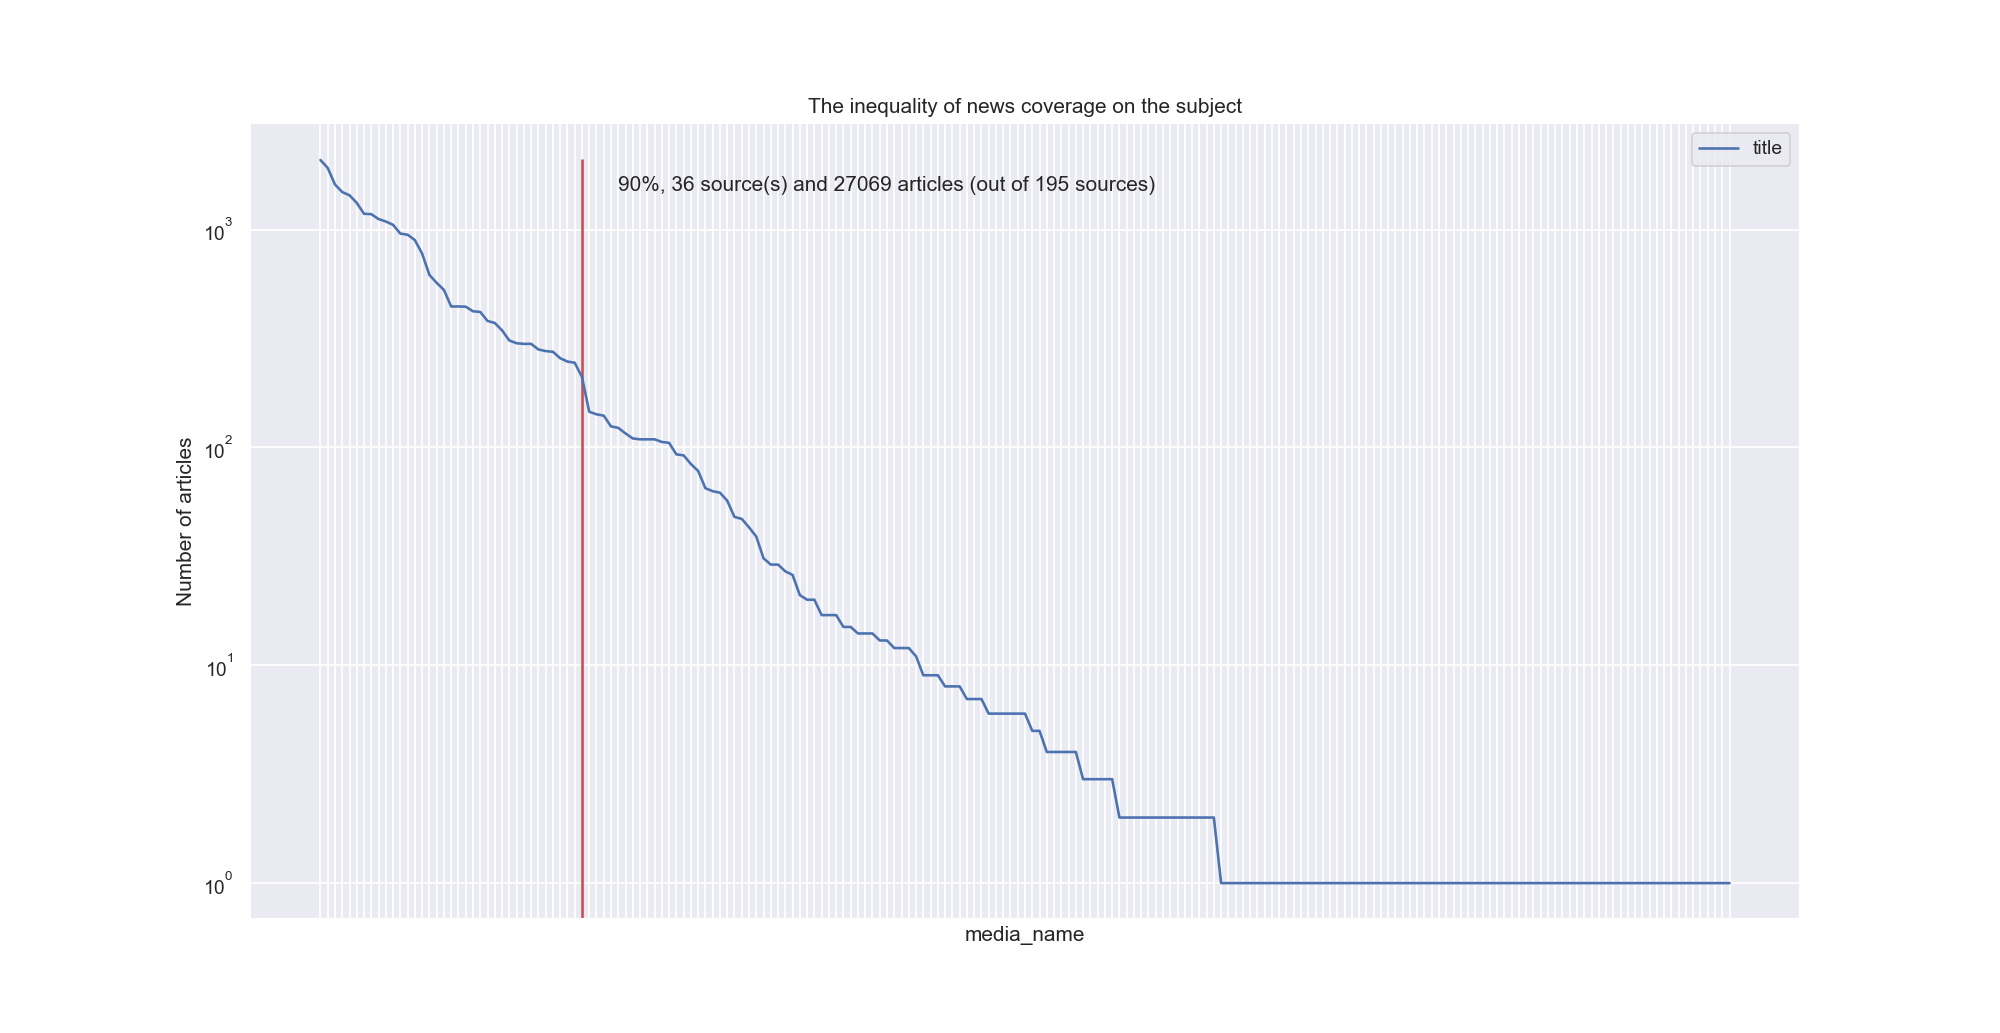

In [12]:
#plotting the coverage of the issue by media house

# Defining the variables for 
totalArticles = 29931
perc = 90

#finding the number of  percentage of
ind, sumArticles =  percent2ind(perc, totalArticles)

ann = str(perc)+'%'+', '+str(ind)+' source(s) and '+str(sumArticles)+' articles ('+'out of '+str(len(total_per_media['title']))+' sources)' 

sns.set('talk')
sns.set_style('ticks')

sns.set(rc={'figure.figsize':(16,8.27)})

mp = sns.lineplot(data = total_per_media)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.vlines(ind, 0, 2100, color = 'r') 

plt.annotate(ann,
            xy=(ind+5, 1500),  
            #xytext=(perDate.index[146], 647),  
            #arrowprops=dict(facecolor='black', shrink=0.05)
            )

plt.yscale('log')
plt.ylabel('Number of articles')
plt.title('The inequality of news coverage on the subject')

#collecteing the top sources
topSources = total_per_media.head(ind).index.tolist()

#Adding media sources codes for later
all_articles['mediaCode'] = [int(total_per_media.index.to_list().index(all_articles.iloc[i,4])) + 1 
                             for i in range(len(all_articles.index))]


In [13]:
all_df = all_articles[ all_articles.media_name.isin(topSources)]

print('The total number of articles after removing media sources with few articles:'+ str(all_df.stories_id.count()))

The total number of articles after removing media sources with few articles:26858


**Plotting the most popular days of the news coverage**

In [14]:
# Grouping : the all articles based on their dates
perDate = all_articles.groupby('date').count()
perDate = perDate.loc[:,['title']]

# Filtering : Removing outlier dates and sticking with the dates of the actual Media Cloud query 
perDate.index = pd.to_datetime(perDate.index) 
perDate = perDate[(perDate.index > '2020-08-31') &
                  (perDate.index < '2021-04-30')]


#Adding Additional column to specify if news was published on weekday or weekend 
dowList = perDate.index.dayofweek.tolist()
perDate['DOW'] = ['Weekday' if (i >= 0 and i <=4) else 'Weekend' for i in dowList ]  

In [15]:
#Most articles published per day
perDate.sort_values(by = 'title', ascending = False).head(10).T

date  2021-01-26 2020-09-21 2020-12-07 2020-12-08 2020-09-20 2021-02-03  \
title        647        592        576        565        552        504   
DOW      Weekday    Weekday    Weekday    Weekday    Weekend    Weekday   

date  2020-09-22 2020-12-01 2020-09-25 2020-12-04  
title        482        459        445        406  
DOW      Weekday    Weekday    Weekday    Weekday

<IPython.core.display.Javascript object>


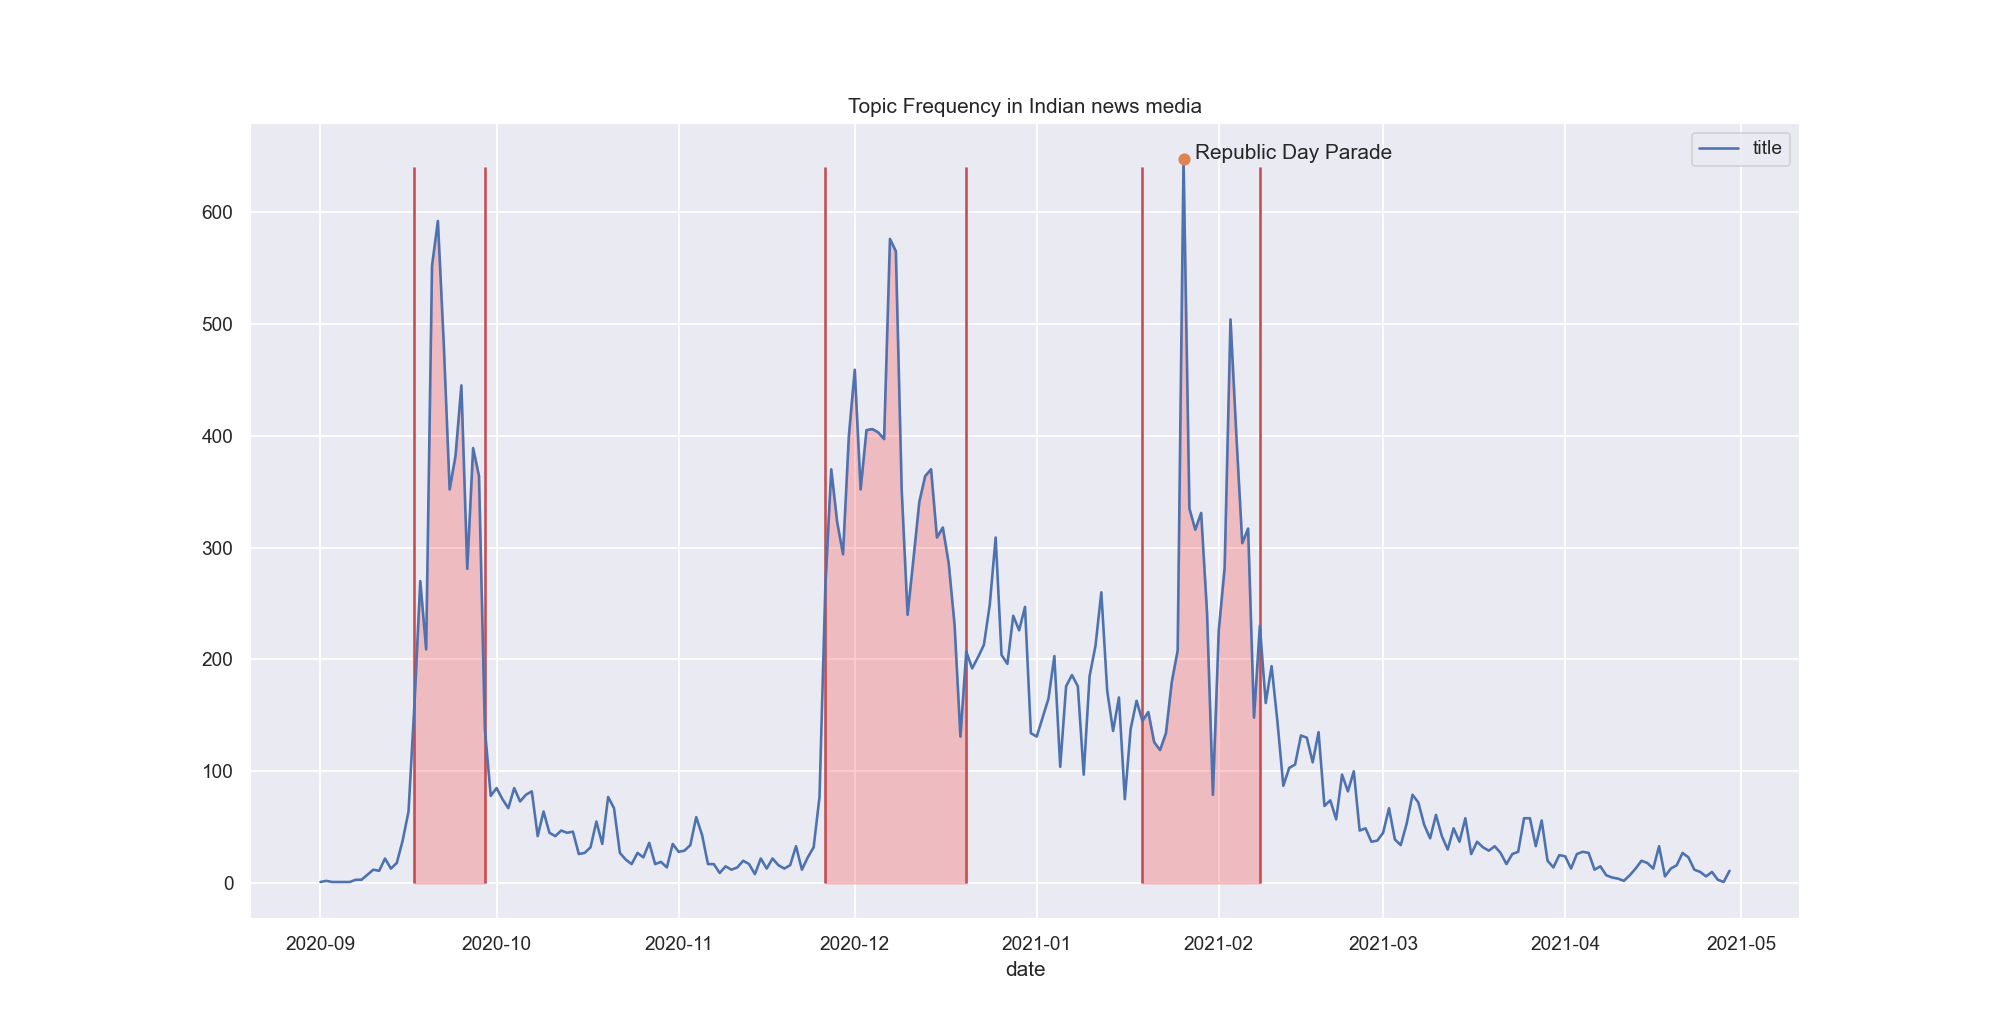

In [16]:
#plotting the graph
sns.set(rc={'figure.figsize':(16,8.27)})
fig, ax = plt.subplots()
sns.lineplot(data = perDate)


#Filling the area of high activity
#Group 1
ax.fill_between( perDate.index, perDate.title.values, where=([x <= (perDate.index[25]) and x >= perDate.index[13]  
                                                              for x in perDate.index]), color = 'red', alpha = 0.2)
#Group 2
ax.fill_between( perDate.index, perDate.title.values, where=([x <= (perDate.index[107]) and x >= perDate.index[83]  
                                                              for x in perDate.index]), color = 'red', alpha = 0.2)
#Group 3
ax.fill_between( perDate.index, perDate.title.values, where=([x <= (perDate.index[157]) and x >= perDate.index[137]  
                                                              for x in perDate.index]), color = 'red', alpha = 0.2)


#highlighting the bounds for the each group
#Group 1
ax.vlines(perDate.index[13], 0, 640, color = 'r')
ax.vlines(perDate.index[25], 0, 640, color = 'r')

#Group 2
ax.vlines(perDate.index[83], 0, 640, color = 'r')
ax.vlines(perDate.index[107], 0, 640, color = 'r')

#Group 3
ax.vlines(perDate.index[137], 0, 640, color = 'r')
ax.vlines(perDate.index[157], 0, 640, color = 'r')


#Annotating the event of highest activity 
ax.plot(perDate.index[144], [647], 'o')
plt.annotate('Republic Day Parade',
            xy=(perDate.index[144], 647),  
            xytext=(perDate.index[146], 647)
            )

#title of the graph
title = plt.title('Topic Frequency in Indian news media')


#plt.savefig('topicFreq.png')

#total rows 238

**Finding out the common words using word cloud** 

<IPython.core.display.Javascript object>


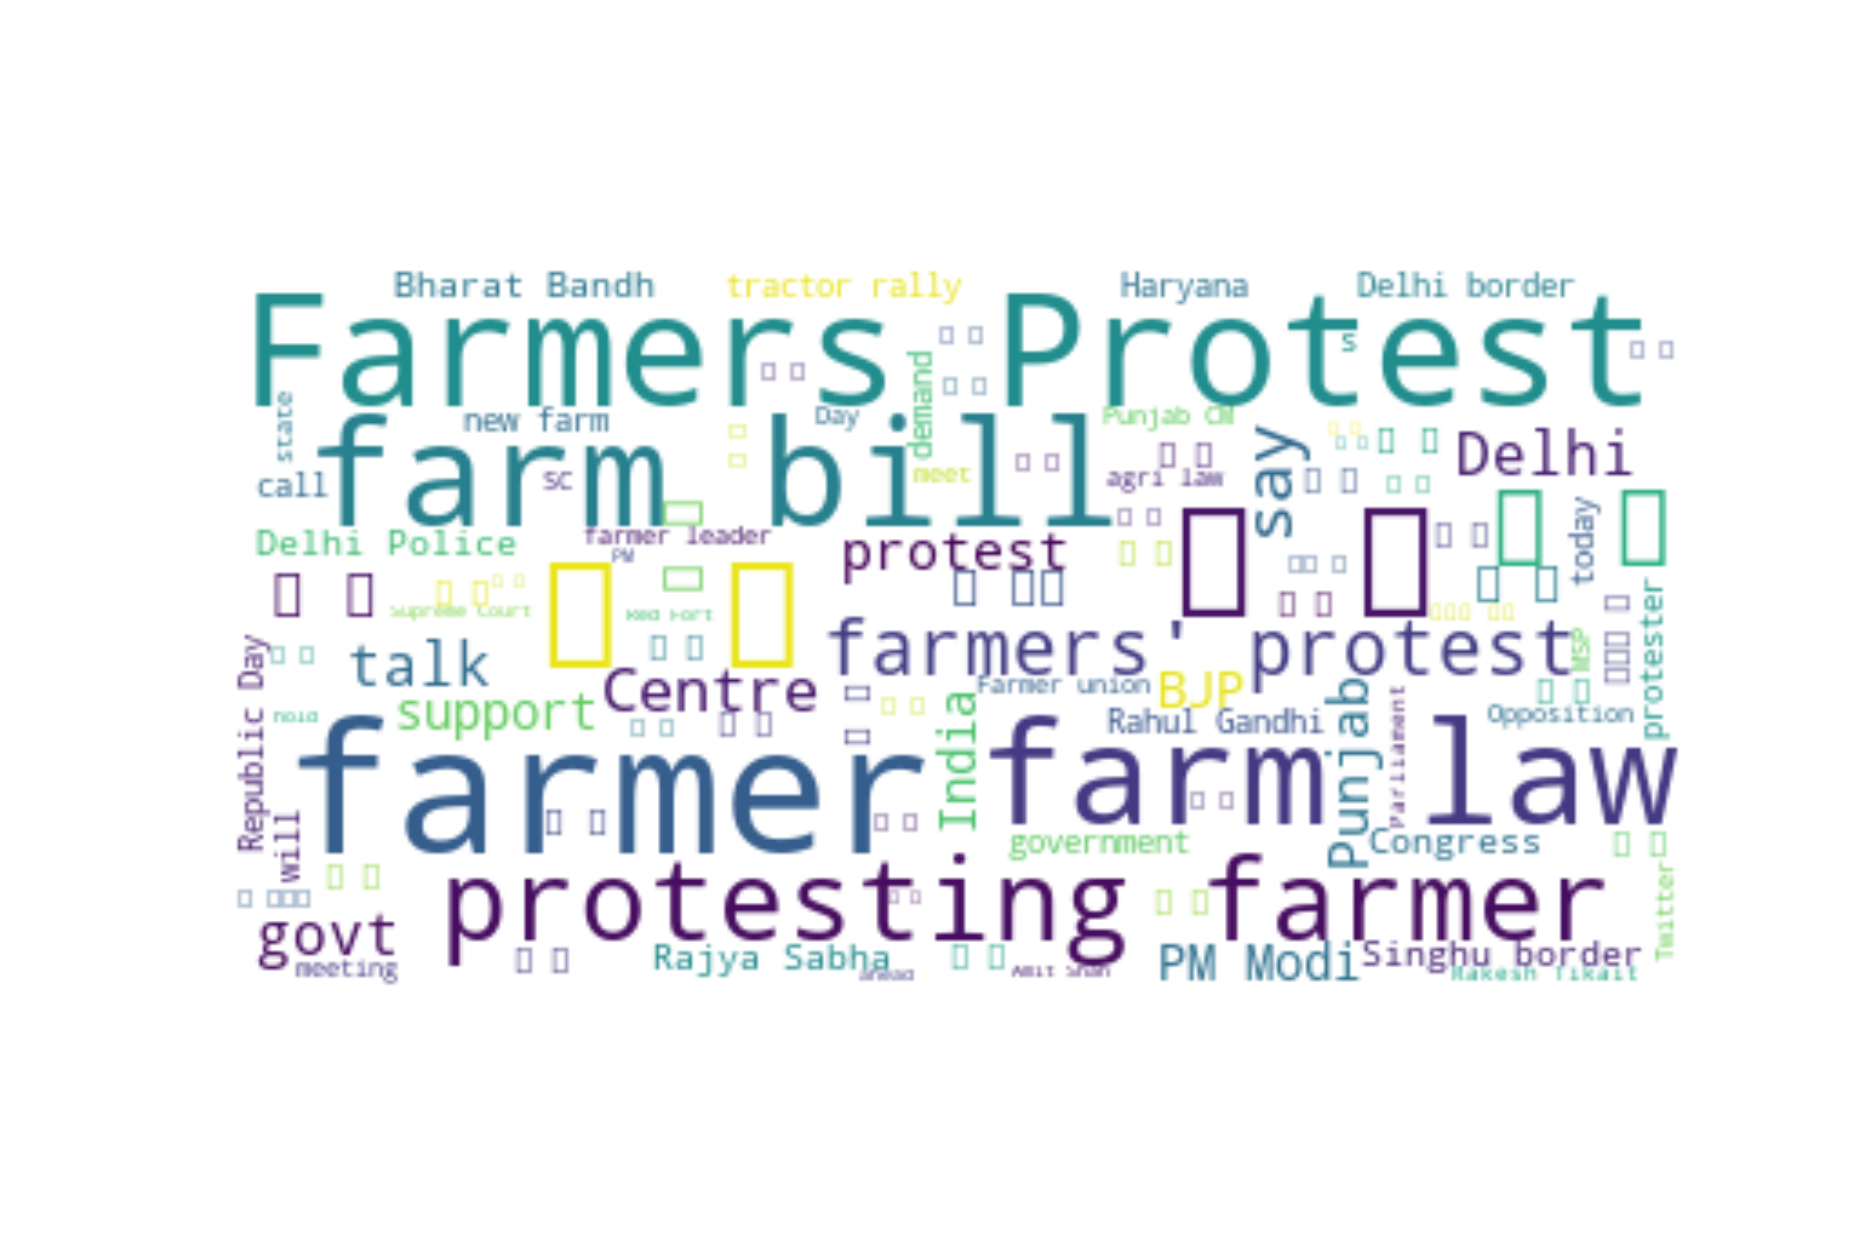

In [17]:
text = " ".join(title for title in all_articles.title)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize = [15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

**Comment:** Because the topic of data is realted to Farmers' protest, it is no surprise that data we see now shows that too. However there are a lot of 'Hindi' words which did not get highlighted. So word cloud is not the best tool to analyse the words used.  

# Pre processing of the data for different time windows

In [18]:
all_df = all_df.reset_index(drop = True)


# Congress
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('oppn', "congress",  row['title'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Oppn', "congress",  row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('INC', "congress", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('UPA', "congress", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Opposition', "congress", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('opposition', "congress", row['titleCleaned'])),axis=1)

#Farm Laws
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Farm Laws', "FarmLaws", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Farm Bills',"FarmBills", row['titleCleaned'])),axis=1)

#FarmersProtest
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Farmers Protest',"FarmersProtest", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Farmers Protests',"FarmersProtest", row['titleCleaned'])),axis=1)

#Rajya Sabha
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Rajya Sabha', "RajyaSabha" , row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('RS', "RajyaSabha",  row['titleCleaned'])),axis=1)

#Prime Minister
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub("Modi", 'pmModi', row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub("PM", 'pmModi', row['titleCleaned'])),axis=1)

#FarmersUnion
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub("Farmer Unions", 'FarmerUnion', row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub("Farmer unions", 'FarmerUnion', row['titleCleaned'])),axis=1)




In [19]:
groupOne =  all_df[(all_df['date'] >= '2020-09-17') & (all_df['date'] <= '2020-09-29')]
groupTwo = all_df[(all_df['date'] >= '2020-11-26') & (all_df['date'] <= '2020-12-20')]
groupThree = all_df[(all_df['date'] >= '2021-01-19') & (all_df['date'] <= '2021-02-08')]

# TF-IDF correlation matrix for each group

In [20]:
def compile_corpus(articleGroup, topSources):
    compile_dict = {'sources': [], 'corpus' : []}
    for i in range(len(topSources)):
        compile_dict['sources'].append(topSources[i])
        compile_dict['corpus'].append(articleGroup[articleGroup.media_name == topSources[i]]['titleCleaned'].tolist())
    
    return pd.DataFrame(compile_dict)

In [21]:
def correlationmat(articleGroup, topSources):
    #compiling the text corpus based on news source
    newCorpus = compile_corpus(articleGroup, topSources)
    newCorpus['allText'] = [' '.join(newCorpus.iloc[i][1]) for i in range(len(newCorpus.corpus))]
    
    #removing stop words
    stops = stop_words = set([i.lower() for i in stopwords.words('english')])
    
    #using TF-IDF vectoriser on all the text
    vectorizer = TfidfVectorizer(stop_words= stops)
    transformed_texts = vectorizer.fit_transform(newCorpus['allText'])
    transformed_text_array = transformed_texts.toarray()
    
    #making a correlation matrix
    correlation_matrix = ((transformed_texts * transformed_texts.T).A)
    labels = newCorpus.sources
    sns.heatmap(correlation_matrix, xticklabels= labels, yticklabels= labels)
    plt.title("Text Similarity")
    #plt.savefig('groupThree.png')

<IPython.core.display.Javascript object>


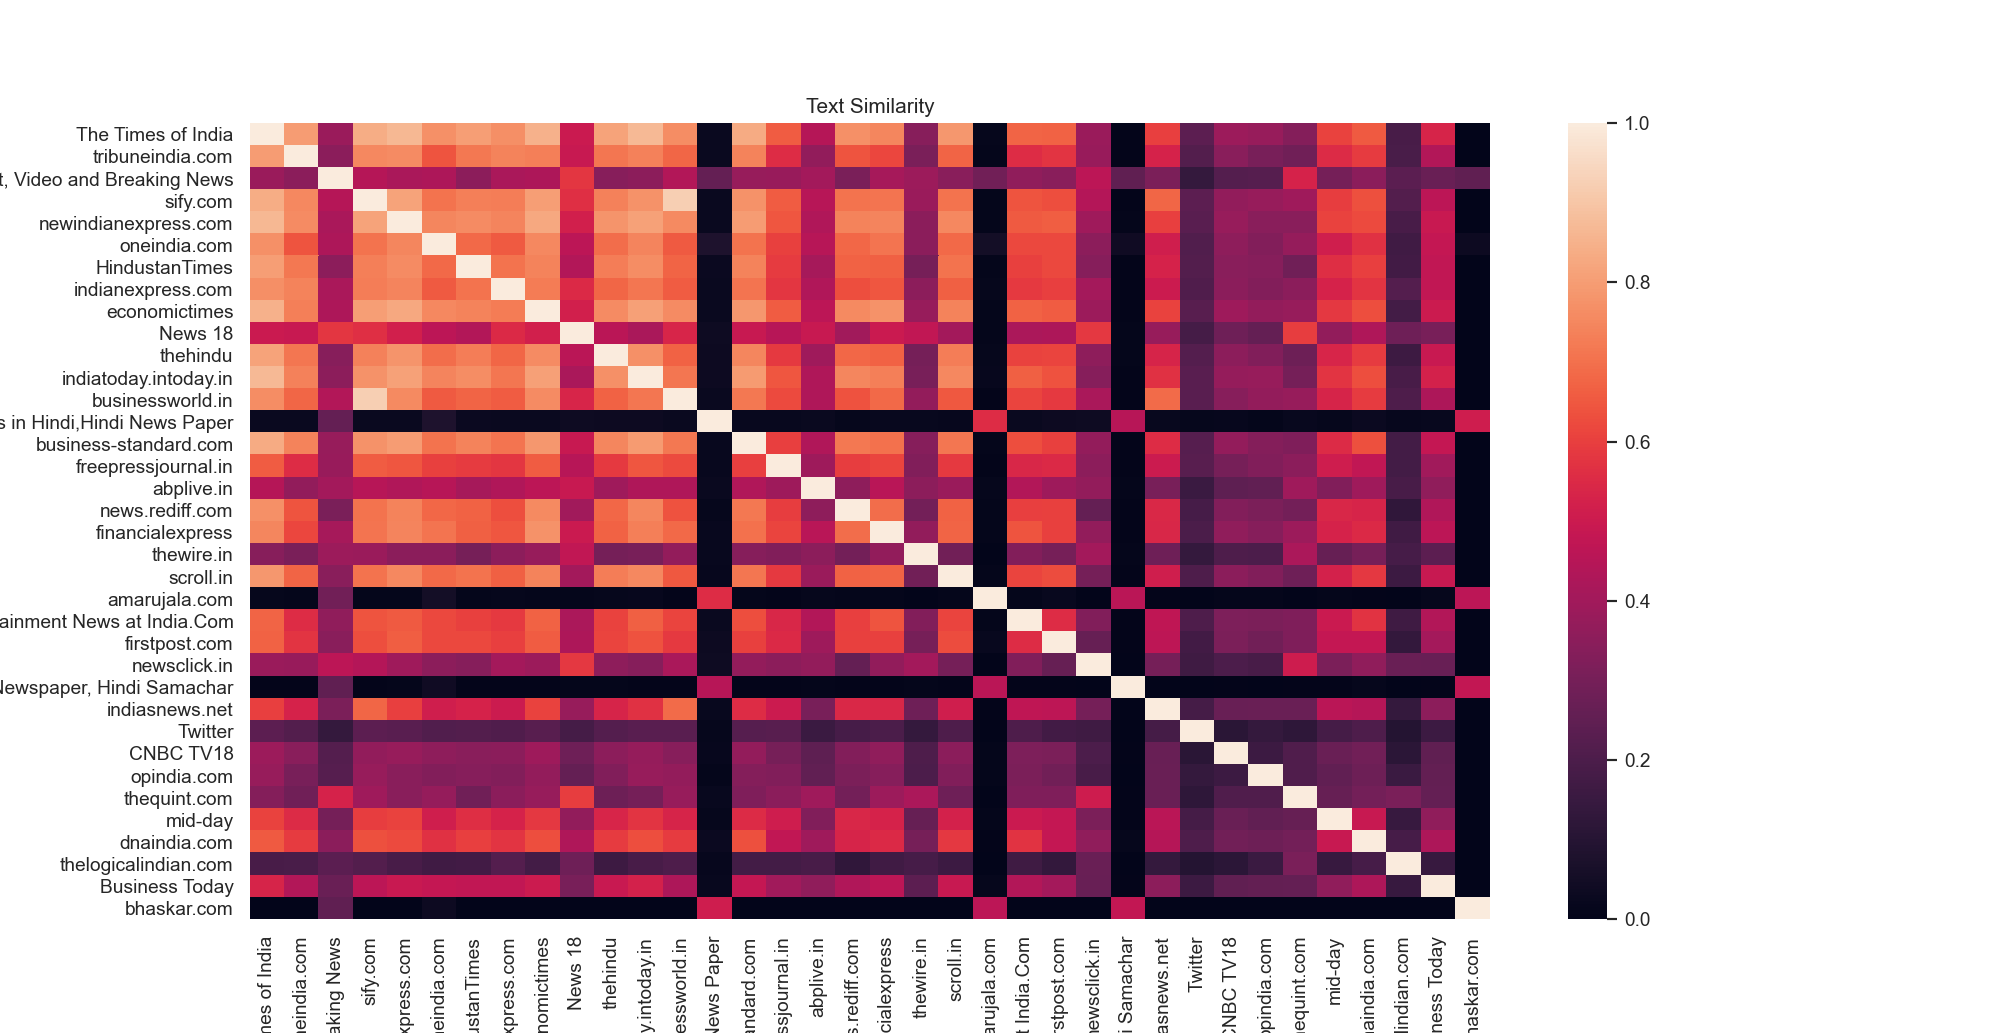

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current

In [22]:
correlationmat(groupOne, topSources)

<IPython.core.display.Javascript object>


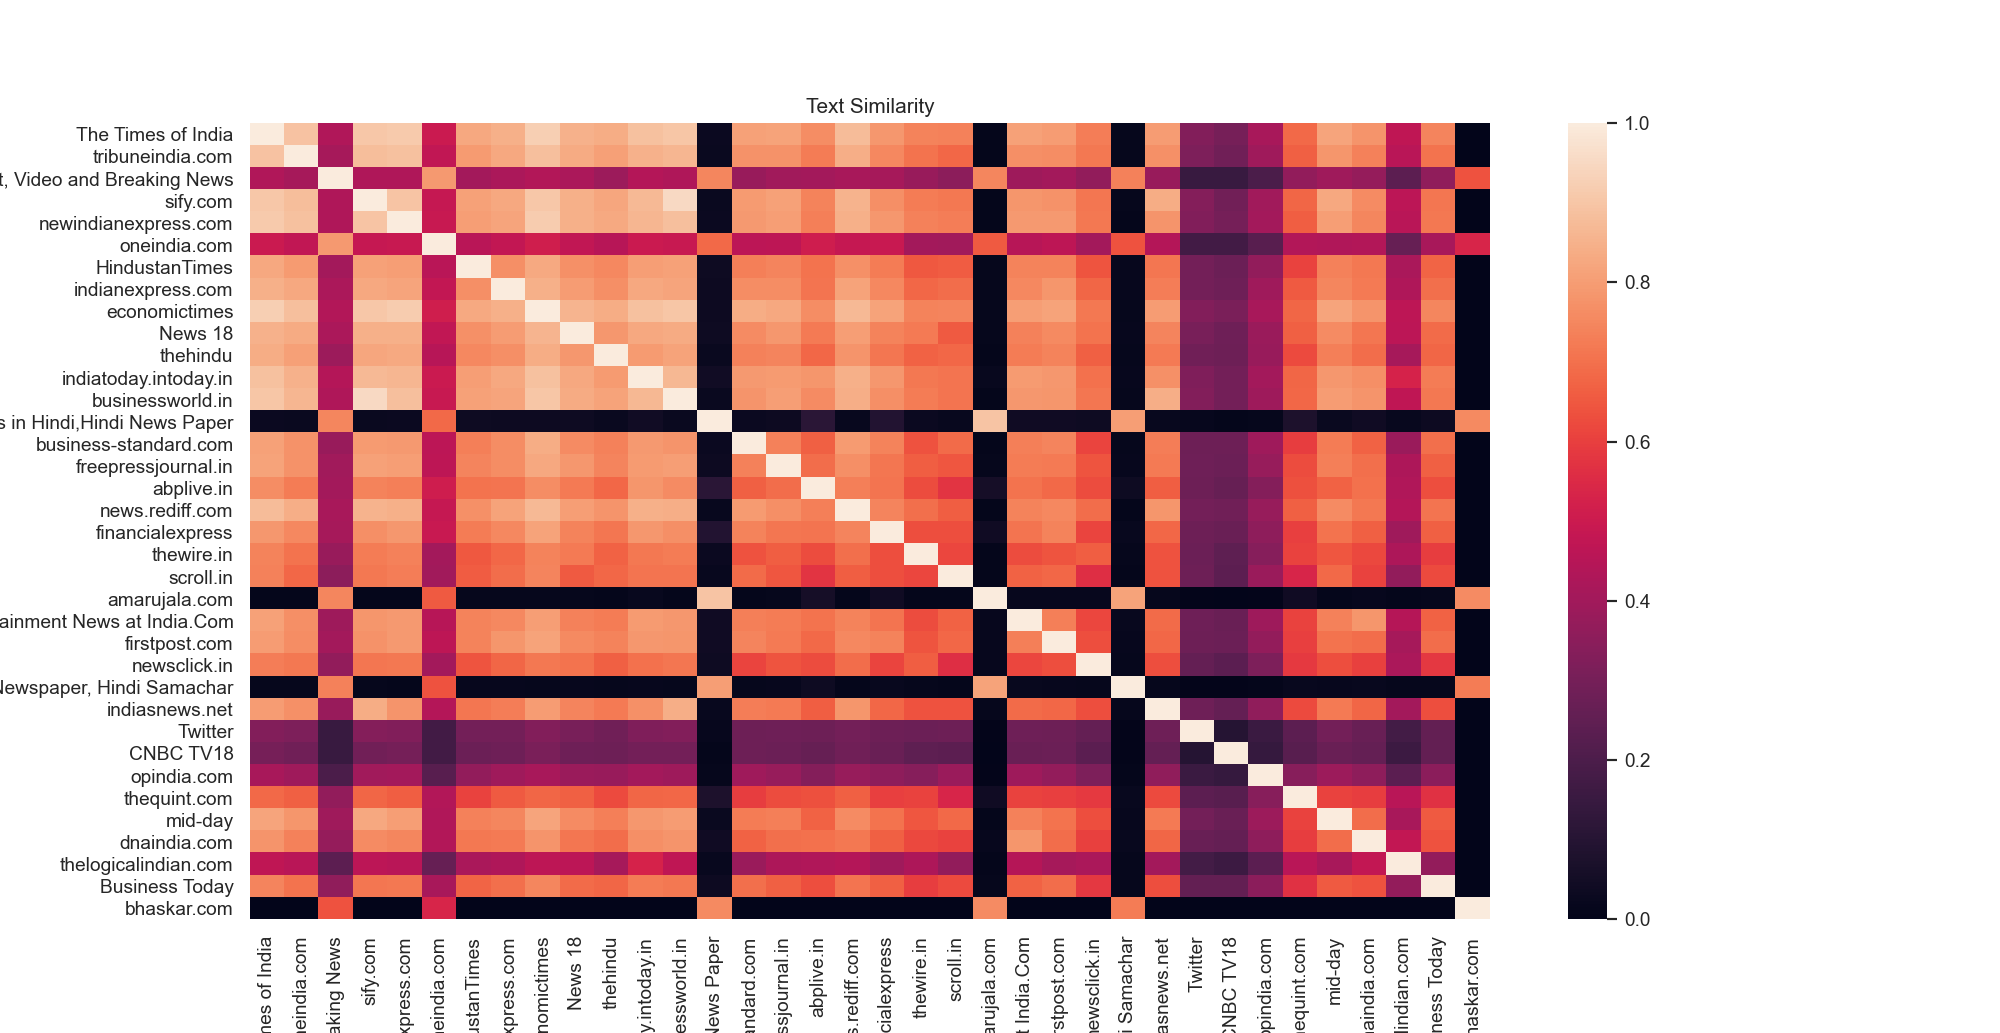

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current

In [171]:
correlationmat(groupTwo, topSources)

<IPython.core.display.Javascript object>


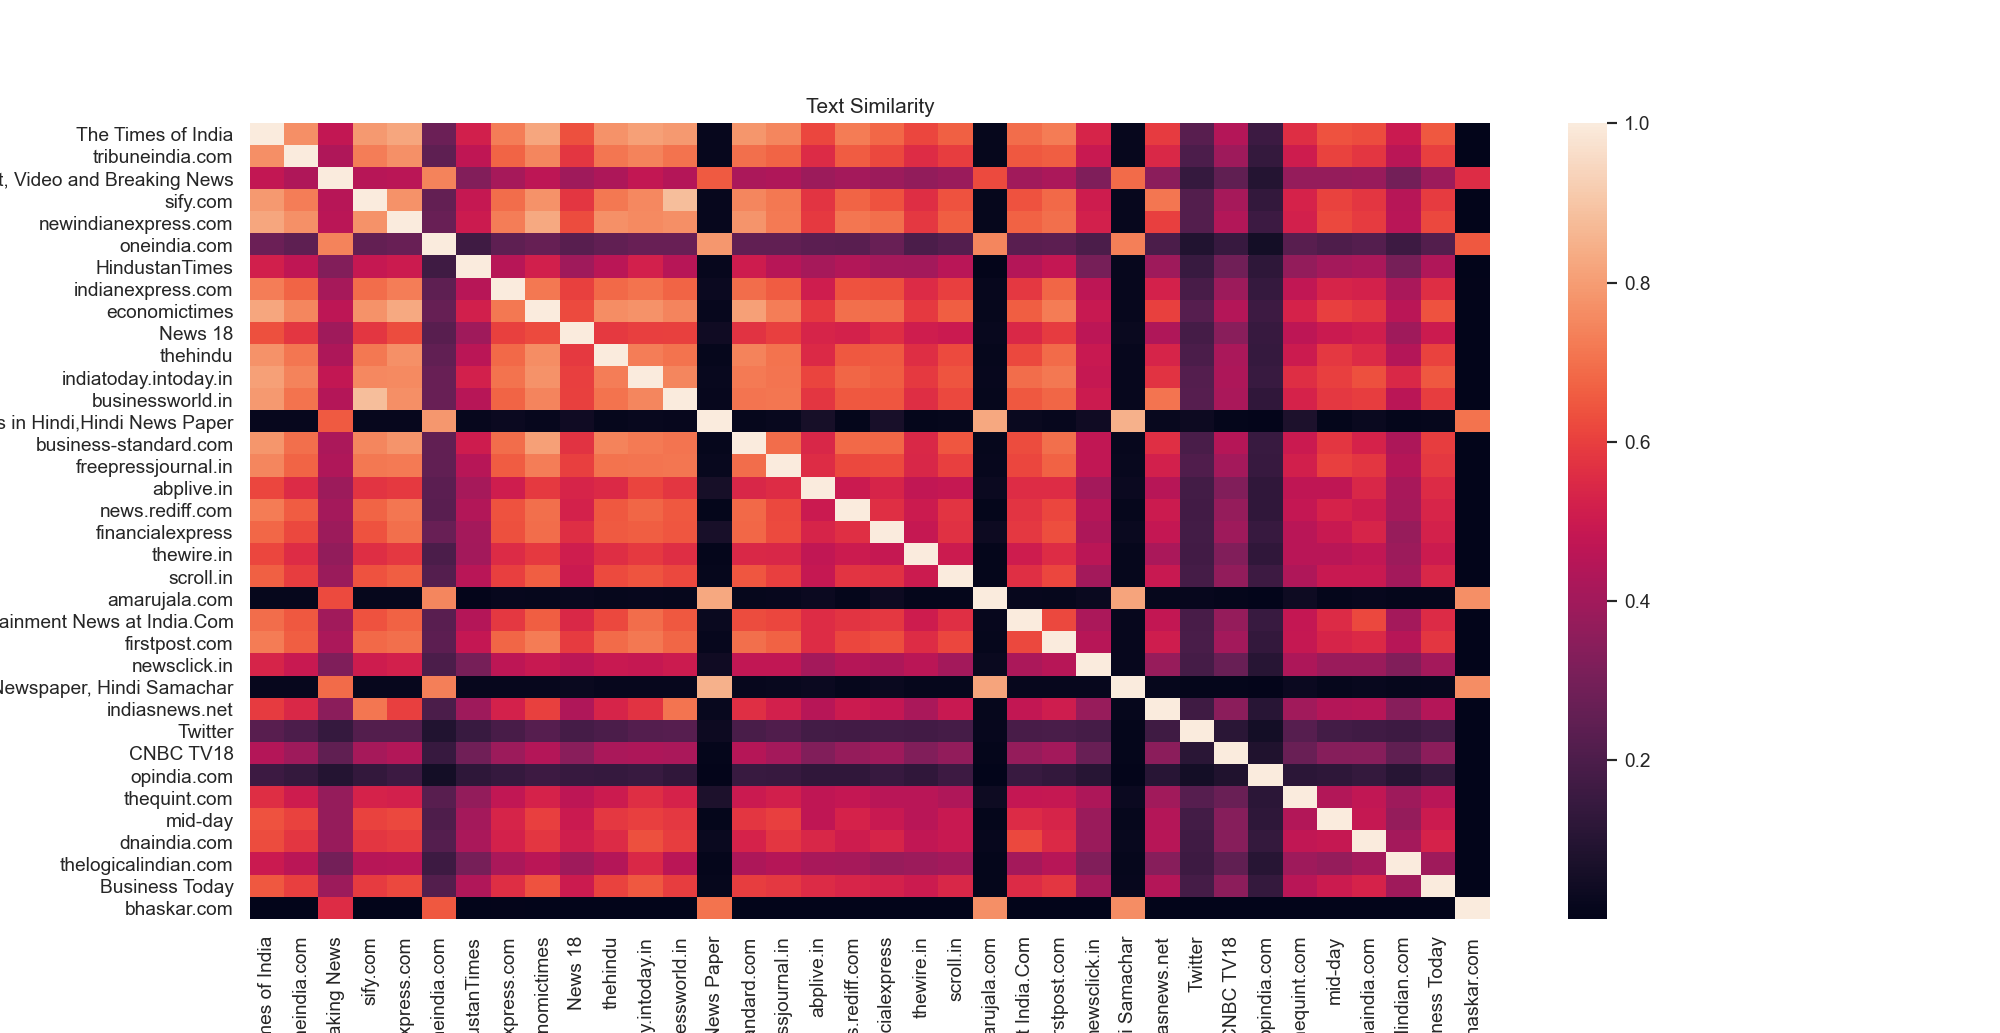

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current

In [172]:
correlationmat(groupThree, topSources)

**Observation:** The hindi newspapers are more similar to each other than english, the context seems to be lost in translation. For a more just comparision the news needs to be translated in english and then compared.

# TF-IDF top ranked words for each group

In [23]:
#resetting the index to compile the groups
groupOne = groupOne.reset_index(drop=True)
groupTwo = groupTwo.reset_index(drop=True)
groupThree = groupThree.reset_index(drop=True)

In [29]:
#Compiling the text from all the groups 
newDict = {'sources' : ['groupOne', 'groupTwo', 'groupThree'],
           'Text' : [groupOne['titleCleaned'].to_list(),
                     groupTwo['titleCleaned'].to_list(),
                     groupThree['titleCleaned'].to_list()]}


newCorpus = pd.DataFrame(newDict)
newCorpus['allText'] = [' '.join(newCorpus.iloc[i][1]) for i in range(len(newCorpus.Text))]

In [212]:
#removing stop words
stops = stop_words = set([i.lower() for i in stopwords.words('english')])

#TF_IDF vectorisation
vectorizer = TfidfVectorizer(stop_words= stops)

transformed_texts = vectorizer.fit_transform(newCorpus['allText'])
transformed_text_array = transformed_texts.toarray()

#########################################################################

#Ranking the high scored TF-IDF words
tf_idf_dataframes = []

#processing each of the group
for counter, txt in enumerate(transformed_text_array):
    
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), txt))
    #Sorting words by TF-IDF scores 
    tf_idf_dataframes.append(pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)['term'])

#Making a Data frame from rankings
tf_idf_doc_comparison = pd.DataFrame(tf_idf_dataframes).T
tf_idf_doc_comparison.columns = newCorpus.sources
tf_idf_doc_comparison.index.names = ['Tf-IDF Ranking']

In [32]:
#Top 15 wrods for each group
tf_idf_doc_comparison.iloc[:15,:36]

sources           groupOne        groupTwo  groupThree
Tf-IDF Ranking                                        
0                    bills         farmers     farmers
1                     farm         protest     protest
2                  farmers           delhi       delhi
3                 congress      protesting      police
4               rajyasabha            farm     tractor
5                farmbills            laws         day
6                  protest          border        farm
7                   pmmodi          centre    violence
8                   punjab          pmmodi       rally
9                      bjp            says        laws
10                    says            govt          पर
11                     mps           bandh        says
12                protests         support  protesting
13              parliament          bharat      pmmodi
14                    govt  farmersprotest    republic

# Embedding-Transformer using SBert and more

In [35]:
#dimensionality reduction and clustering

def encodeNCluster(embeddings, n_components, newsData, dim = 2, n_neighbours = 15):
    umap_embeddings = umap.UMAP(n_neighbors = n_neighbours, n_components= n_components,metric='cosine').fit_transform(embeddings)
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
    
    umap_data = umap.UMAP(n_neighbors=n_neighbours, n_components=dim, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    
    if dim == 3: 
        result = pd.DataFrame(umap_data, columns=['x', 'y', 'z'])
    else: 
        result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result.index = newsData.index
    result['labels'] = cluster.labels_
    result['title'] = newsData['title']
    result['newspaper'] = newsData['media_name']
    result['Days']= newsData['Day']
    result['mediaCode'] = newsData['mediaCode'] 
    return result, cluster

# Visualize clusters in 2D with variability slider
def plot2d(result, perDay = False, cmapby = 'labels'):
    fig, ax = plt.subplots(figsize=(10, 8))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]

    topvis = plt.scatter(clustered.x.values, clustered.y.values, c=clustered[cmapby].values , s=0.05, 
                         cmap= 'hsv_r') 
    plt.colorbar()


    plt.subplots_adjust(bottom=0.25)
    saxis =  plt.axes([0.25, 0.1, 0.65, 0.03])
    time_slider = Slider(ax = saxis, label = "date", valmin = result.Days.min(), 
                        valmax = result.Days.max(), 
                        valinit= result.Days.min(), valstep = 1)

    def update(val):
        if perDay:
            x = clustered[clustered.Days == time_slider.val].x.values
            y = clustered[clustered.Days == time_slider.val].y.values
        else: 
            x = clustered[clustered.Days < time_slider.val].x.values
            y = clustered[clustered.Days < time_slider.val].y.values            

        topvis.set_offsets(np.vstack ((x, y)).T)
        draw()

    time_slider.on_changed(update)

    plt.show()
    return fig, ax, time_slider

# Visualize clusters in 3D with variability slider    
def plot3d(result, perDay = False ):    
    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(projection='3d')
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]

    top3dvis = ax.scatter(clustered.x.values, clustered.y.values, clustered.z.values, 
                           c=clustered.labels , s=0.05, cmap= 'tab20c') #'hsv_r')


    plt.subplots_adjust(bottom=0.25)
    saxis =  plt.axes([0.25, 0.1, 0.65, 0.03])
    timer_slider = Slider(ax = saxis, label = "Day", valmin = result.Days.min(), 
                        valmax = result.Days.max(), 
                        valinit= result.Days.min(), valstep = 1)

    def update(val):
        if perDay:    
            x = clustered[clustered.Days == timer_slider.val].x.values
            y = clustered[clustered.Days == timer_slider.val].y.values
            z = clustered[clustered.Days == timer_slider.val].z.values
            col = clustered[clustered.Days == timer_slider.val].labels.values
        else: 
            x = clustered[clustered.Days < timer_slider.val].x.values
            y = clustered[clustered.Days < timer_slider.val].y.values
            z = clustered[clustered.Days < timer_slider.val].z.values
            col = clustered[clustered.Days < timer_slider.val].labels.values
        ax.clear()
        ax.scatter(x, y,z , c=col , s=0.05, cmap='hsv_r')

        fig.canvas.draw_idle()

    timer_slider.on_changed(update)

    plt.show()
    return fig, ax, timer_slider

In [33]:
#Loading mbert model
model_mbert = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

#mBert result for Group 1
embeddings_mbert_G1 = model_mbert.encode(groupOne['titleCleaned'].tolist(), show_progress_bar=True)

#mBert result for Group 2
embeddings_mbert_G2 = model_mbert.encode(groupTwo['titleCleaned'].tolist(), show_progress_bar=True)

#mBert result for Group 3
embeddings_mbert_G3 = model_mbert.encode(groupThree['titleCleaned'].tolist(), show_progress_bar=True)

<IPython.core.display.Javascript object>


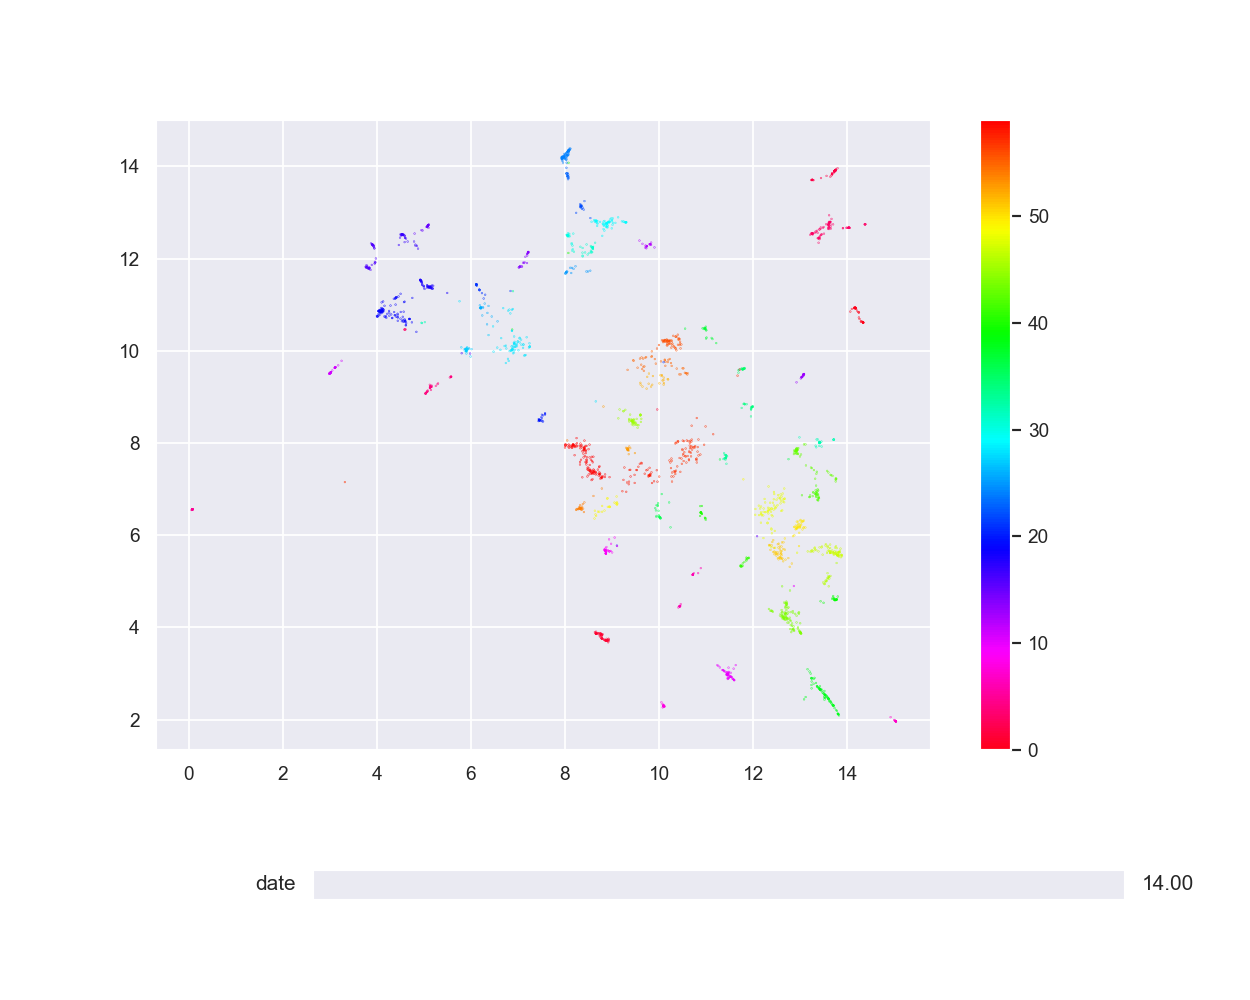

(<Figure size 1000x800 with 3 Axes>,
 <matplotlib.widgets.Slider at 0x1f3a4d1c370>)

In [39]:
#result for group 1
result_G1, cluster_G1 = encodeNCluster(embeddings_mbert_G1, 5, groupOne,  n_neighbours = 15)
plot2d(result_G1)

<IPython.core.display.Javascript object>


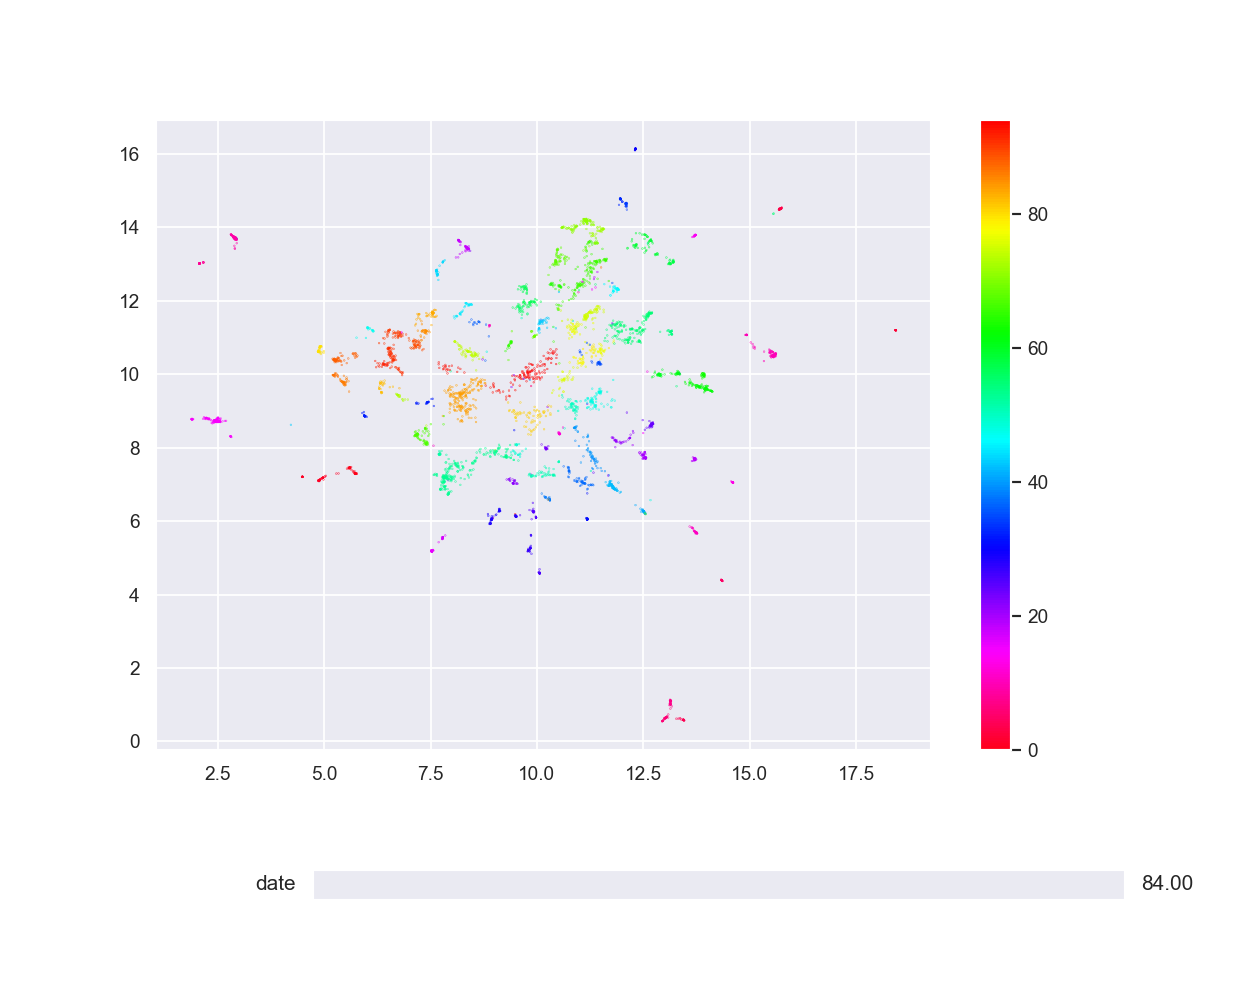

(<Figure size 1000x800 with 3 Axes>,
 <matplotlib.widgets.Slider at 0x1f3a469bdc0>)

In [40]:
#result for group 2
result_G2, cluster_G2 = encodeNCluster(embeddings_mbert_G2, 5, groupTwo,  n_neighbours = 15)
plot2d(result_G2)

<IPython.core.display.Javascript object>


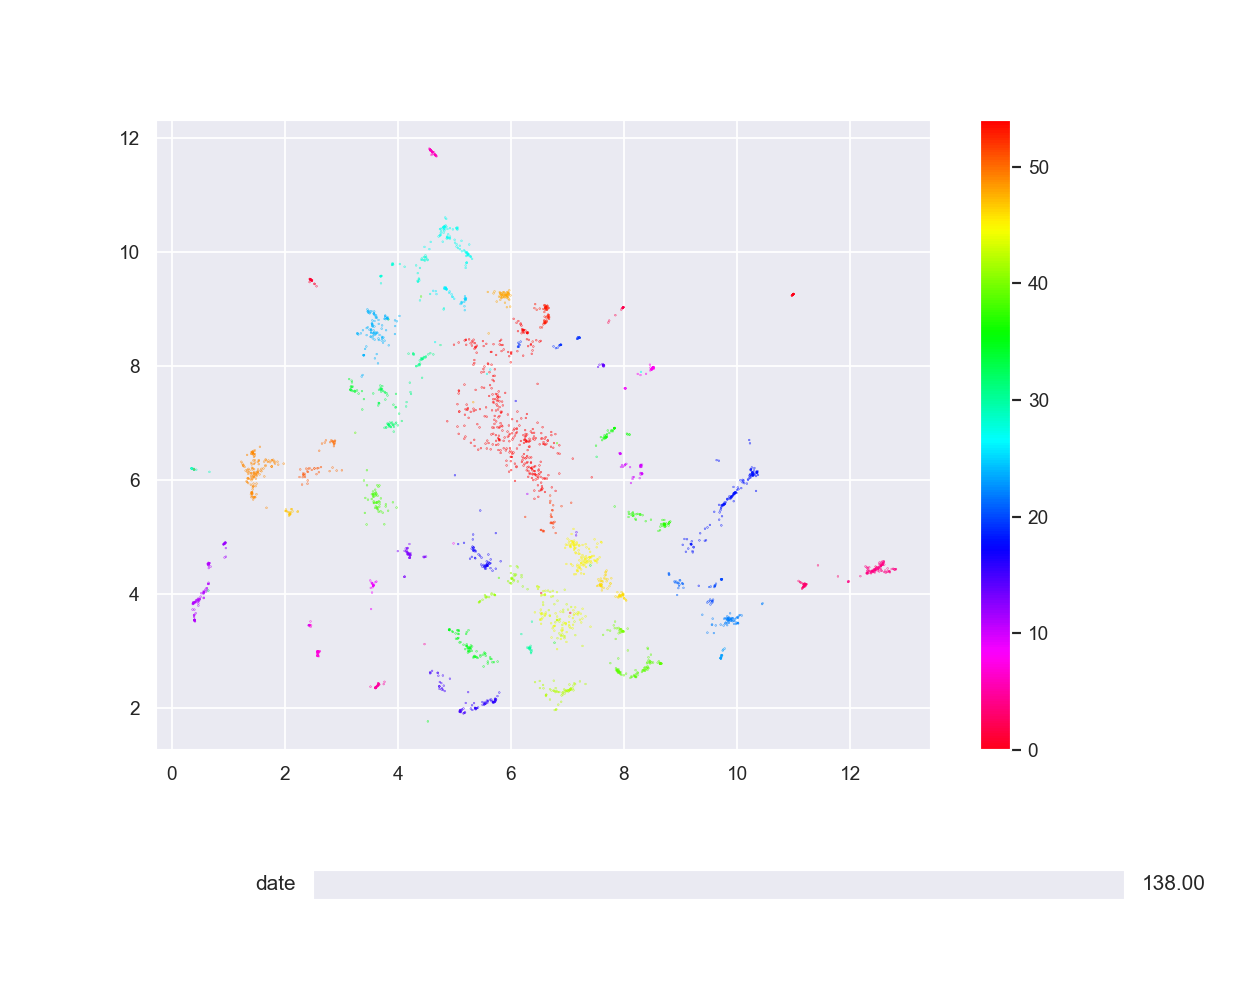

(<Figure size 1000x800 with 3 Axes>,
 <matplotlib.widgets.Slider at 0x1f3a4148130>)

In [38]:
#result for group 3
result_G3, cluster_G3 = encodeNCluster(embeddings_mbert_G3, 5, groupThree,  n_neighbours = 15)
plot2d(result_G3)

In [48]:
#Example result
result_G1[result_G1.labels == 2].title.values

array(["'Sad, disappointing', says Sukhbir Singh Badal as farm Bills get President's nod",
       'President Gives Assent To Jammu and Kashmir Official Languages Bill',
       "Farm bills get President's nod; Opposition says 'dark day for democracy'",
       'News18 Daybreak |  President Gives Nod to 3 Farm Bills, Maharashtra Says No to Implementation and Other Stories You Need to Watch Out For',
       "President Kovind gives assent to three farm bills amid country-wide farmers' protest",
       "'Extremely unfortunate': Sukhbir Singh Badal on Presidential assent to farmers and J-K bills",
       'President nod To Farm Bills: Capt explores state law tweak; Sukhbir says ready to join any struggle',
       'Amid intensifying protests, President Kovind gives assent to controversial farm bills, laws come into force immediately',
       'President Kovind gives assent to 3 farm bills passed by Parliament',
       'President Kovind gives nod to three farm bills cleared by Parliament',
      

# Creating network of the newspapers covering similar frames

In [54]:
def NormComparisionDf(result):
    
    #extract clusters and newspapers from the results
    nxresult = result[result.labels > -1].sort_values(by = 'labels')
    nxresult = nxresult.loc[:, ['newspaper', 'labels']]
    
    #defining the list of labels and sources for the loop 
    labelList = sorted(result.labels.unique())[1:]
    allSources = result[result.labels != -1].newspaper.unique()
    
    #instatiating the group proportion dictionary 
    groupDict = {}

    for i in range(len(allSources)):
        #total coverage by the newspaper during the certain period
        allCoverage = nxresult.newspaper.value_counts()[allSources[i]]
        
        #defining the list of variables 
        groupDict[allSources[i]] = []
        
        for j in labelList:
            #if the newspaper is in the frame cluster
            if allSources[i] in nxresult[nxresult.labels == j].newspaper.values:

                #coverage by the newspaper in the particular group
                groupCoverage = nxresult[nxresult.labels == j].newspaper.value_counts()[allSources[i]]

                #proportion of coverage by newspaper in the j label group
                coverageProp = groupCoverage/allCoverage
                
                #adding the proportion of the news coverage in j label from i newspaper
                groupDict[allSources[i]].append(coverageProp)
            
            else:
                
                #if not in the cluster of label j then append zero in the list
                groupDict[allSources[i]].append(0)


    return pd.DataFrame(groupDict, index = labelList)      
        

In [51]:
#results from 
NormComparisionDf(result_G1).T

0         1   \
economictimes                                       0.025000  0.025000   
newindianexpress.com                                0.007937  0.031746   
The Times of India                                  0.010204  0.030612   
indianexpress.com                                   0.009091  0.009091   
thehindu                                            0.028302  0.028302   
sify.com                                            0.018634  0.037267   
business-standard.com                               0.000000  0.032967   
businessworld.in                                    0.033708  0.033708   
Business Today                                      0.000000  0.000000   
thequint.com                                        0.000000  0.041667   
opindia.com                                         0.000000  0.000000   
News 18                                             0.019608  0.019608   
scroll.in                                           0.000000  0.000000   
NDTV.com: India, Business, Bollywood, Cricket, ...  0.017241  0.034483   
tribuneindia.com                                    0.012048  0.036145   
indiatoday.intoday.in                               0.021505  0.010753   
firstpost.com                                       0.000000  0.000000   
abplive.in                                          0.000000  0.000000   
Twitter                                             0.000000  0.000000   
indiasnews.net                                      0.037037  0.037037   
news.rediff.com                                     0.040000  0.040000   
oneindia.com                                        0.013514  0.027027   
freepressjournal.in                                 0.000000  0.060606   
HindustanTimes                                      0.016760  0.016760   
mid-day                                             0.000000  0.000000   
amarujala.com                                       0.000000  0.000000   
bhaskar.com                                         0.000000  0.000000   
financialexpress                                    0.071429  0.000000   
India | Latest India News | Get Free India.com ...  0.000000  0.030303   
newsclick.in                                        0.000000  0.043478   
CNBC TV18                                           0.060606  0.030303   
thewire.in                                          0.000000  0.000000   
thelogicalindian.com                                0.000000  0.000000   
dnaindia.com                                        0.000000  0.000000   
Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hindi...  0.000000  0.000000   
Dainik Jagran:Hindi News,Latest News in Hindi,N...  0.000000  0.000000   

                                                          2         3   \
economictimes                                       0.025000  0.075000   
newindianexpress.com                                0.015873  0.039683   
The Times of India                                  0.020408  0.025510   
indianexpress.com                                   0.018182  0.054545   
thehindu                                            0.018868  0.009434   
sify.com                                            0.018634  0.049689   
business-standard.com                               0.010989  0.043956   
businessworld.in                                    0.022472  0.056180   
Business Today                                      0.038462  0.000000   
thequint.com                                        0.041667  0.041667   
opindia.com                                         0.000000  0.000000   
News 18                                             0.019608  0.026144   
scroll.in                                           0.021277  0.042553   
NDTV.com: India, Business, Bollywood, Cricket, ...  0.025862  0.025862   
tribuneindia.com                                    0.018072  0.042169   
indiatoday.intoday.in                               0.021505  0.043011   
firstpost.com                                       0.071429 

In [55]:
def PairwiseWeights(result, weightColName ):
    
    #weight will be calculated based on results from columns
    weights = cosine_similarity(NormComparisionDf(result).T)
    edgesDict = {'Source A':[], 'Source B': [], weightColName:[]}
    
    #Collection sources from results
    allSources = result[result.labels != -1].newspaper.unique()

    for i in  range(len(allSources)):
        for j in range(i+1 , len(allSources)):

            #tuple of source pair
            edgesDict['Source A'].append(allSources[i])
            edgesDict['Source B'].append(allSources[j])

            #adding normalised weight
            edgesDict[weightColName].append(weights[i][j])

    return pd.DataFrame(edgesDict)

In [56]:
pairwise_G1 = PairwiseWeights(result_G1, 'weight_G1')
pairwise_G2 = PairwiseWeights(result_G2, 'weight_G2')
pairwise_G3 = PairwiseWeights(result_G3, 'weight_G3')

In [57]:
#merging all the pairwise weights
compDf = pd.merge(pd.merge(pairwise_G1,pairwise_G2 , on = ['Source A', 'Source B'] ), pairwise_G3, on =['Source A', 'Source B']).fillna(0)
compDf

Source A                                           Source B  \
0    economictimes                                     Business Today   
1    economictimes                                       thequint.com   
2    economictimes                                        opindia.com   
3    economictimes                                            News 18   
4    economictimes                                          scroll.in   
..             ...                                                ...   
222      CNBC TV18                                       dnaindia.com   
223      CNBC TV18  Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hind...   
224     thewire.in                               thelogicalindian.com   
225     thewire.in                                       dnaindia.com   
226     thewire.in  Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hind...   

     weight_G1  weight_G2  weight_G3  
0     0.499262   0.718383   0.505464  
1     0.570396   0.368962   0.473117  
2     0.465633   0.604706   0.277976  
3     0.707860   0.755532   0.508809  
4     0.714420   0.511362   0.737467  
..         ...        ...        ...  
222   0.432562   0.372697   0.525447  
223   0.496139   0.177929   0.480147  
224   0.452863   0.143201   0.276243  
225   0.484293   0.287707   0.328852  
226   0.173585   0.277077   0.800042  

[227 rows x 5 columns]

In [63]:
compDf.sort_values(by = 'weight_G1', ascending = False)

Source A           Source B  weight_G1  weight_G2  weight_G3
50     The Times of India     HindustanTimes   0.858651   0.871828   0.489294
32     The Times of India  indianexpress.com   0.847909   0.767894   0.821192
14   newindianexpress.com           sify.com   0.825310   0.853421   0.841176
39     The Times of India            News 18   0.820028   0.832593   0.584714
33     The Times of India           sify.com   0.797790   0.837591   0.864263
..                    ...                ...        ...        ...        ...
131        Business Today        bhaskar.com   0.030773   0.097962   0.536266
130        Business Today      amarujala.com   0.028583   0.236625   0.271328
123      businessworld.in        bhaskar.com   0.026293   0.235807   0.400860
208               mid-day        bhaskar.com   0.000000   0.370574   0.326705
200   freepressjournal.in        bhaskar.com   0.000000   0.197321   0.479784

[227 rows x 5 columns]

In [64]:
#calculating sum of deltas
compDf['sum of deltas'] = abs(compDf['weight_G1'] - compDf['weight_G2']) + abs(compDf['weight_G2'] - compDf['weight_G3']) + abs(compDf['weight_G1'] - compDf['weight_G3'])
compDf

Source A                                           Source B  \
0    economictimes                                     Business Today   
1    economictimes                                       thequint.com   
2    economictimes                                        opindia.com   
3    economictimes                                            News 18   
4    economictimes                                          scroll.in   
..             ...                                                ...   
222      CNBC TV18                                       dnaindia.com   
223      CNBC TV18  Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hind...   
224     thewire.in                               thelogicalindian.com   
225     thewire.in                                       dnaindia.com   
226     thewire.in  Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hind...   

     weight_G1  weight_G2  weight_G3  sum of deltas  
0     0.499262   0.718383   0.505464       0.438242  
1     0.570396   0.368962   0.473117       0.402867  
2     0.465633   0.604706   0.277976       0.653460  
3     0.707860   0.755532   0.508809       0.493448  
4     0.714420   0.511362   0.737467       0.452210  
..         ...        ...        ...            ...  
222   0.432562   0.372697   0.525447       0.305500  
223   0.496139   0.177929   0.480147       0.636419  
224   0.452863   0.143201   0.276243       0.619323  
225   0.484293   0.287707   0.328852       0.393171  
226   0.173585   0.277077   0.800042       1.252914  

[227 rows x 6 columns]

In [65]:
#reciprocal of sum of deltas
compDf = compDf.sort_values(by = 'sum of deltas')

compDf['weight'] = 1/compDf['sum of deltas']
compDf

Source A  \
63                                   indianexpress.com   
14                                newindianexpress.com   
142  NDTV.com: India, Business, Bollywood, Cricket,...   
141  NDTV.com: India, Business, Bollywood, Cricket,...   
7                                        economictimes   
..                                                 ...   
198                                       oneindia.com   
95                                            thehindu   
191                                       oneindia.com   
226                                         thewire.in   
189                                    news.rediff.com   

                                              Source B  weight_G1  weight_G2  \
63                                      Business Today   0.564132   0.561632   
14                                            sify.com   0.825310   0.853421   
142                                      firstpost.com   0.563345   0.599606   
141                              indiatoday.intoday.in   0.779361   0.786090   
7                                  freepressjournal.in   0.694419   0.737519   
..                                                 ...        ...        ...   
198  Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hind...   0.256074   0.572310   
95   Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hind...   0.589768   0.186654   
191                                      amarujala.com   0.253551   0.614206   
226  Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hind...   0.173585   0.277077   
189                                      amarujala.com   0.121628   0.435717   

     weight_G3  sum of deltas     weight  
63    0.546173       0.035918  27.841341  
14    0.841176       0.056223  17.786378  
142   0.580782       0.072522  13.788922  
141   0.743532       0.085117  11.748576  
7     0.740881       0.092924  10.761431  
..         ...            ...        ...  
198   0.787695       1.063241   0.940520  
95    0.732811       1.092313   0.915489  
191   0.833956       1.160811   0.861467  
226   0.800042       1.252914   0.798139  
189   0.770794       1.298331   0.770219  

[227 rows x 7 columns]

In [66]:
#Average weights
compDf['avg weight'] = (compDf['weight_G1'] + compDf['weight_G2'] + compDf['weight_G3']   ) /3

compDf.sort_values(by = 'avg weight', ascending = False).head(50)

Source A  \
14                                newindianexpress.com   
33                                  The Times of India   
41                                  The Times of India   
32                                  The Times of India   
42                                  The Times of India   
141  NDTV.com: India, Business, Bollywood, Cricket,...   
34                                  The Times of India   
147  NDTV.com: India, Business, Bollywood, Cricket,...   
39                                  The Times of India   
15                                newindianexpress.com   
35                                  The Times of India   
21                                newindianexpress.com   
50                                  The Times of India   
7                                        economictimes   
61                                   indianexpress.com   
102                                           sify.com   
19                                newindianexpress.com   
166                              indiatoday.intoday.in   
24                                newindianexpress.com   
146  NDTV.com: India, Business, Bollywood, Cricket,...   
84                                            thehindu   
77                                            thehindu   
99                                            sify.com   
66                                   indianexpress.com   
47                                  The Times of India   
49                                  The Times of India   
48                                  The Times of India   
10                                       economictimes   
169                              indiatoday.intoday.in   
149  NDTV.com: India, Business, Bollywood, Cricket,...   
93                                            thehindu   
40                                  The Times of India   
140  NDTV.com: India, Business, Bollywood, Cricket,...   
148  NDTV.com: India, Business, Bollywood, Cricket,...   
170                              indiatoday.intoday.in   
119                                   businessworld.in   
69                                   indianexpress.com   
62                                   indianexpress.com   
3                                        economictimes   
143  NDTV.com: India, Business, Bollywood, Cricket,...   
44                                  The Times of India   
4                                        economictimes   
100                                           sify.com   
183                                         abplive.in   
154  NDTV.com: India, Business, Bollywood, Cricket,...   
55                                  The Times of India   
78                                            thehindu   
27                                newindianexpress.com   
56                                  The Times of India   
72                                   indianexpress.com   

                                              Source B  weight_G1  weight_G2  \
14                                            sify.com   0.825310   0.853421   
33                                            sify.com   0.797790   0.837591   
41                                    tribuneindia.com   0.760197   0.802681   
32                                   indianexpress.com   0.847909   0.767894   
42                               indiatoday.intoday.in   0.762553   0.805656   
141                              indiatoday.intoday.in   0.779361   0.786090   
34                               business-standard.com   0.784316   0.668213   
147                                       oneindia.com   0.710343   0.775109   
39                                             News 18   0.820028   0.832593   
15                               business-standard.com   0.739896   0.632163   
35                                    businessworld.in   0.675491   0.792661   
21                               indiatoday.intoday.in   0.609037   0.805040   
50                                      Hindust

<IPython.core.display.Javascript object>


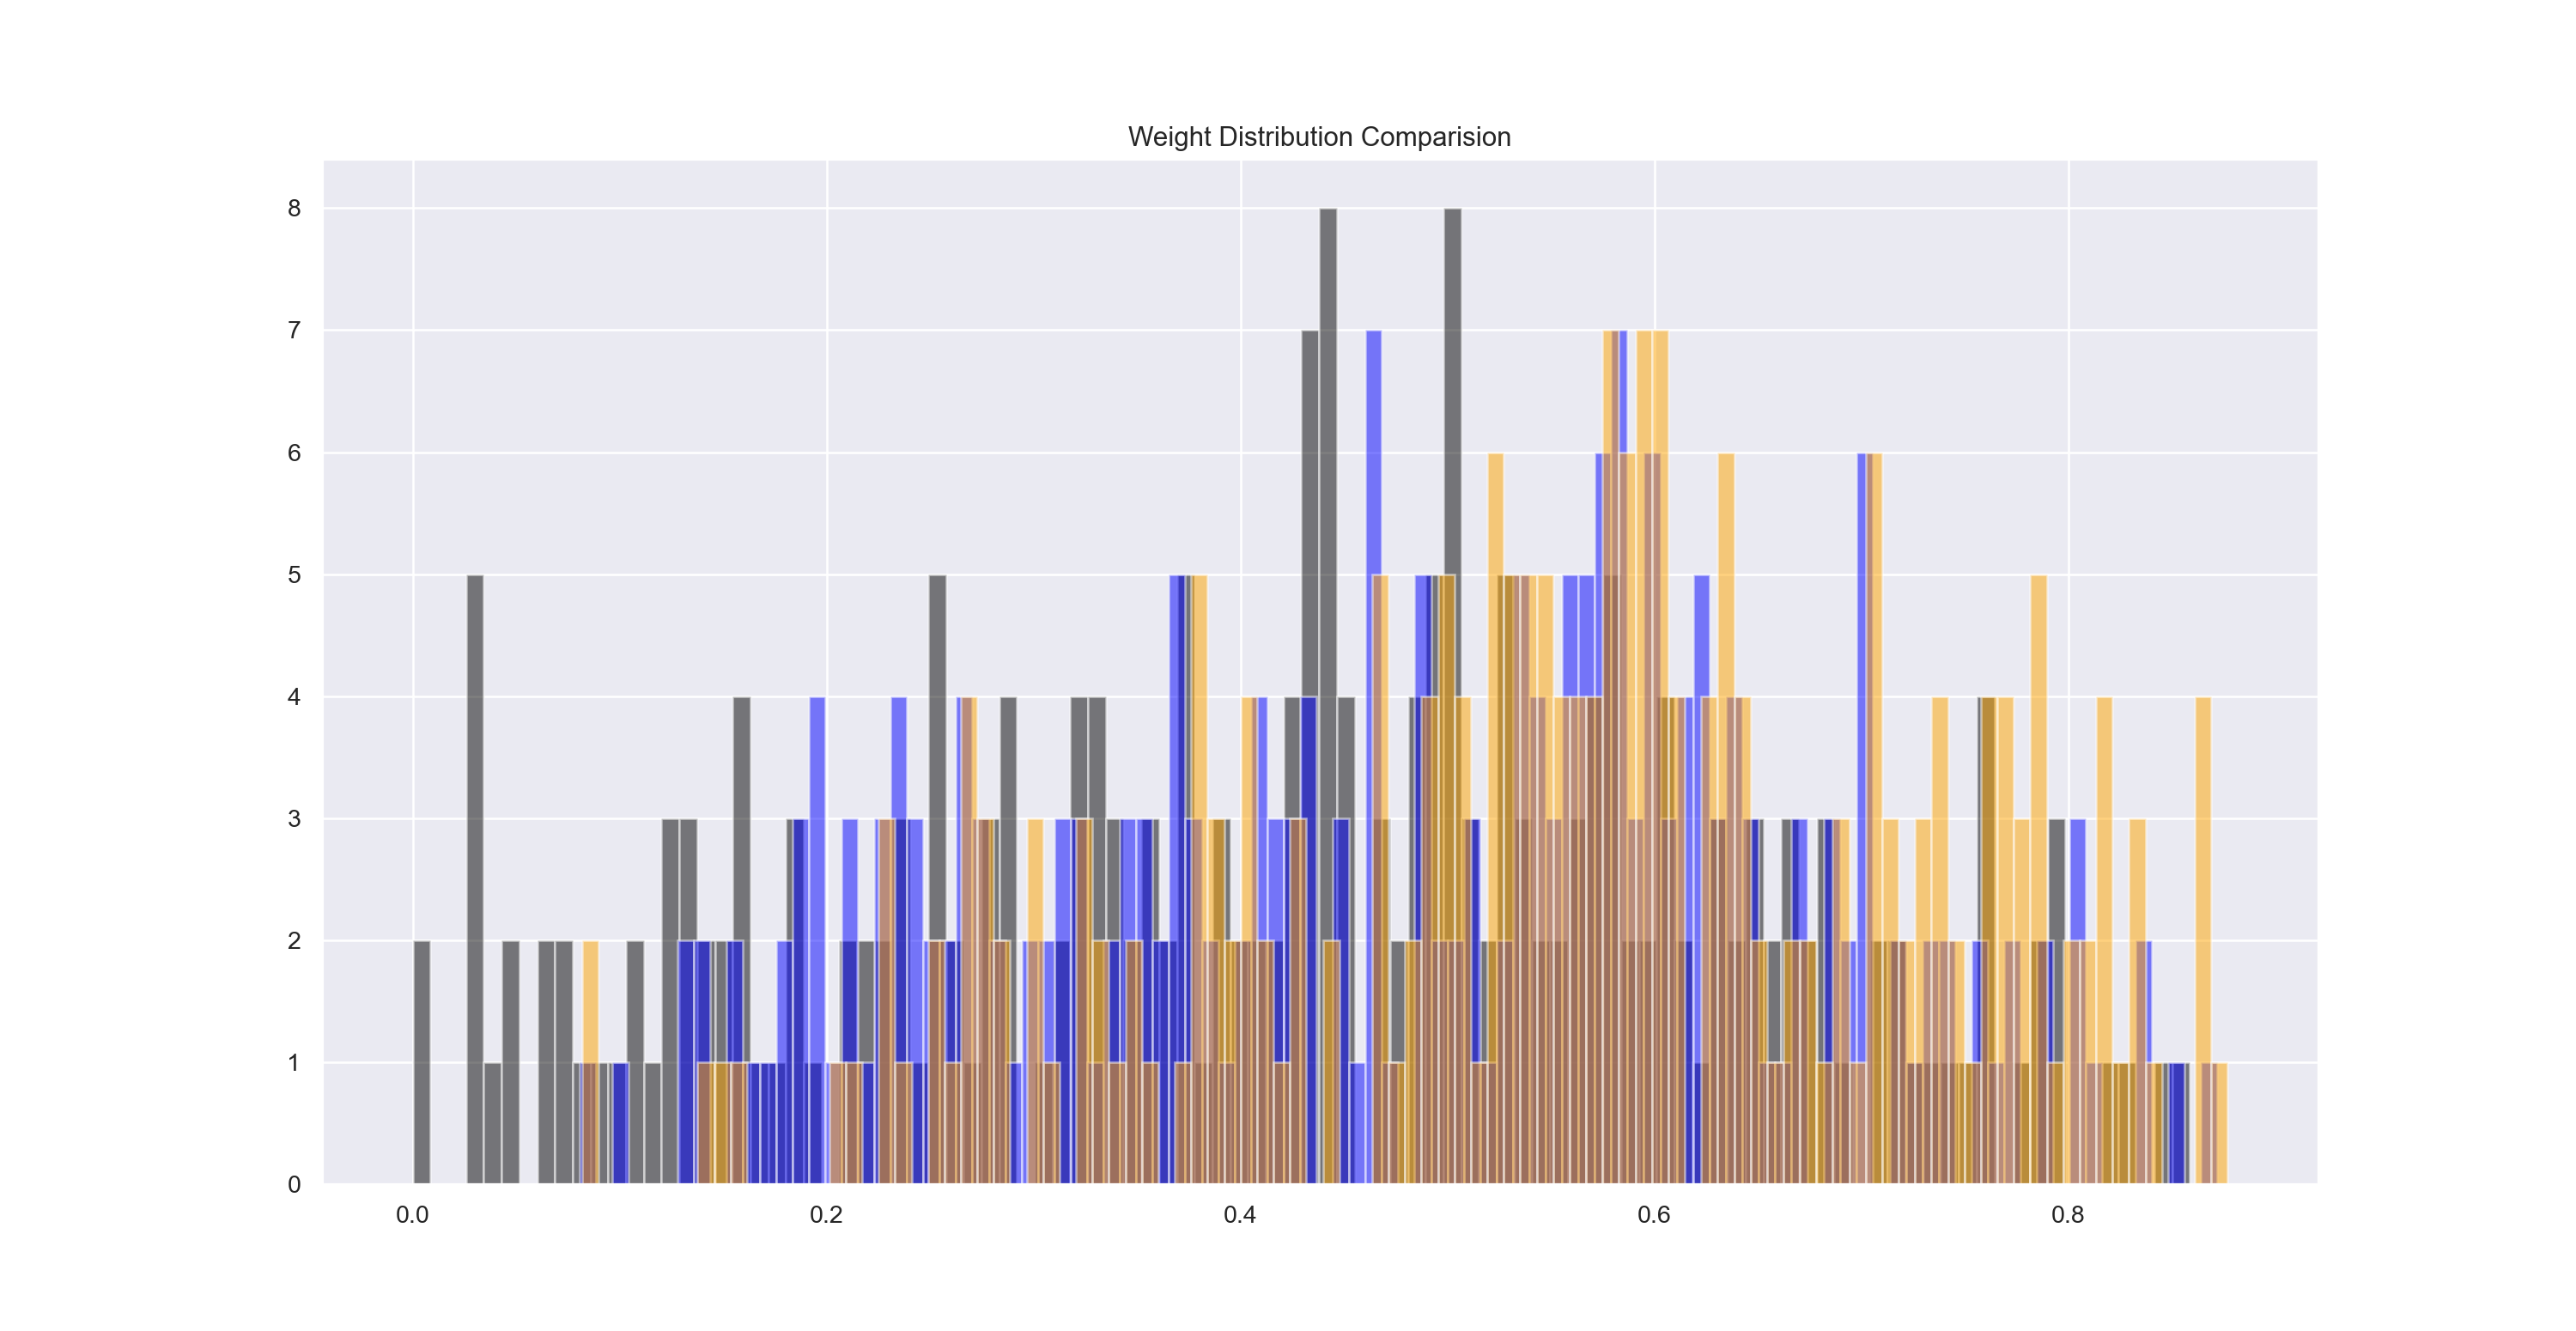

In [67]:
#Weight distribution
plt.figure(dpi= 150)
plt.hist(compDf['weight_G1'], bins = 100, color= 'black', alpha = .5, label = 'group 1')
plt.hist(compDf['weight_G2'], bins = 100, color= 'blue', alpha = .5, label = 'group 2')
plt.hist(compDf['weight_G3'], bins = 100, color= 'orange', alpha = .5, label= 'group 3')
plt.title('Weight Distribution Comparision')
plt.show()

# Creating graphs and building communities from the weights attained.

In [75]:
#Creating networks from the newspapers and weights

G1 = nx.from_pandas_edgelist (compDf,
                            source= 'Source A',
                            target= 'Source B',
                            edge_attr= 'weight_G1'
                            )

G2 = nx.from_pandas_edgelist (compDf,
                            source= 'Source A',
                            target= 'Source B',
                            edge_attr= 'weight_G2'
                            )

G3 = nx.from_pandas_edgelist (compDf,
                            source= 'Source A',
                            target= 'Source B',
                            edge_attr= 'weight_G3'
                            )

In [76]:
#Function to draw adjcency matrix
def draw_grp_adj(Gx, measures, weightAtrr):
    plt.figure(dpi = 150)
    
    #using the measures, grouping the nodes with their communities
    ordered = list(dict(sorted(measures.items(), key=lambda item: item[-1])).keys())
    
    #finding the partitions for the patches
    measurecount = dict(Counter(list(dict(sorted(measures.items(), key=lambda item: item[-1])).values())))
    partitions = list(measurecount.values())
    
    plt.imshow(nx.to_numpy_matrix(Gx, nodelist = ordered, weight = weightAtrr))
    cbar = plt.colorbar()
    #cbar.set_ticks([0,1])
    cbar.set_label('Weight', rotation=270)
    current_idx = 0
    ax = plt.gca()
    
    #adding squares using matplotlib patches for each group 
    for partition in partitions:
        ax.add_patch(patch.Rectangle((current_idx, current_idx),
                                     partition, # Width
                                     partition, # Height
                                     facecolor="none",
                                     edgecolor='red',
                                     linewidth="2"))
        current_idx += partition
    
    #Adding colorbar for the adjacent matrix
    #cbar.ax.set_yticklabels(['Zero', 'One'])
    cbar.set_label('weights', rotation = 270)
    
    #adding labels to the adjacency matrix graph
    plt.xlabel('node idx')
    plt.ylabel('node idx')
    plt.title('Community adjacency matrix')
    plt.show()
    
## For this question we will be using Louvain best fit method to spot the communities

def draw_clu(G, pos, measures, measure_name):
  
    # Create an array to contain the clusters which have been found
    clusters=np.array(list(set(measures.values())))

    # Create a figure to draw the plots and charts
    plt.figure(dpi = 150)

    # Create the plot of the network to be placed in the figure
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), 
                                   node_color=list(measures.values()),
                                   nodelist=list(measures.keys()),
                                   linewidths= 0)


    # Add labels to the plot
    labels = nx.draw_networkx_labels(G, pos,font_size = 5)

    # Add edges to the plot
    edges = nx.draw_networkx_edges(G, pos,  width= 0.1)

    # Create the title of the plot
    plt.title(measure_name)

    # Add a colour bar to act as a legend
    cb = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Communities')
    cb.ax.tick_params(length=0)
    
    # Adds the community labels to the colour bar
    cb.set_ticklabels(list(set(measures.values())))


    nodes.set_clim(-0.5, len(clusters)-0.5)

    # Show the plot without the x/y axis
    plt.axis('off')
    plt.show()

In [77]:
res = .9

pos1 = nx.spring_layout(G1, seed = 84)
louvain1 = community.community_louvain.best_partition(G1, random_state= 333,resolution= res,weight='weight_G1')

pos2 = nx.spring_layout(G2, seed = 84)
louvain2 = community.community_louvain.best_partition(G2, random_state= 333,resolution= res, weight='weight_G2')

pos3 = nx.spring_layout(G3, seed = 84)
louvain3 = community.community_louvain.best_partition(G3, random_state= 333,resolution= res, weight='weight_G3')



In [524]:
#G1.edges(data = True)
#louvain1


<IPython.core.display.Javascript object>


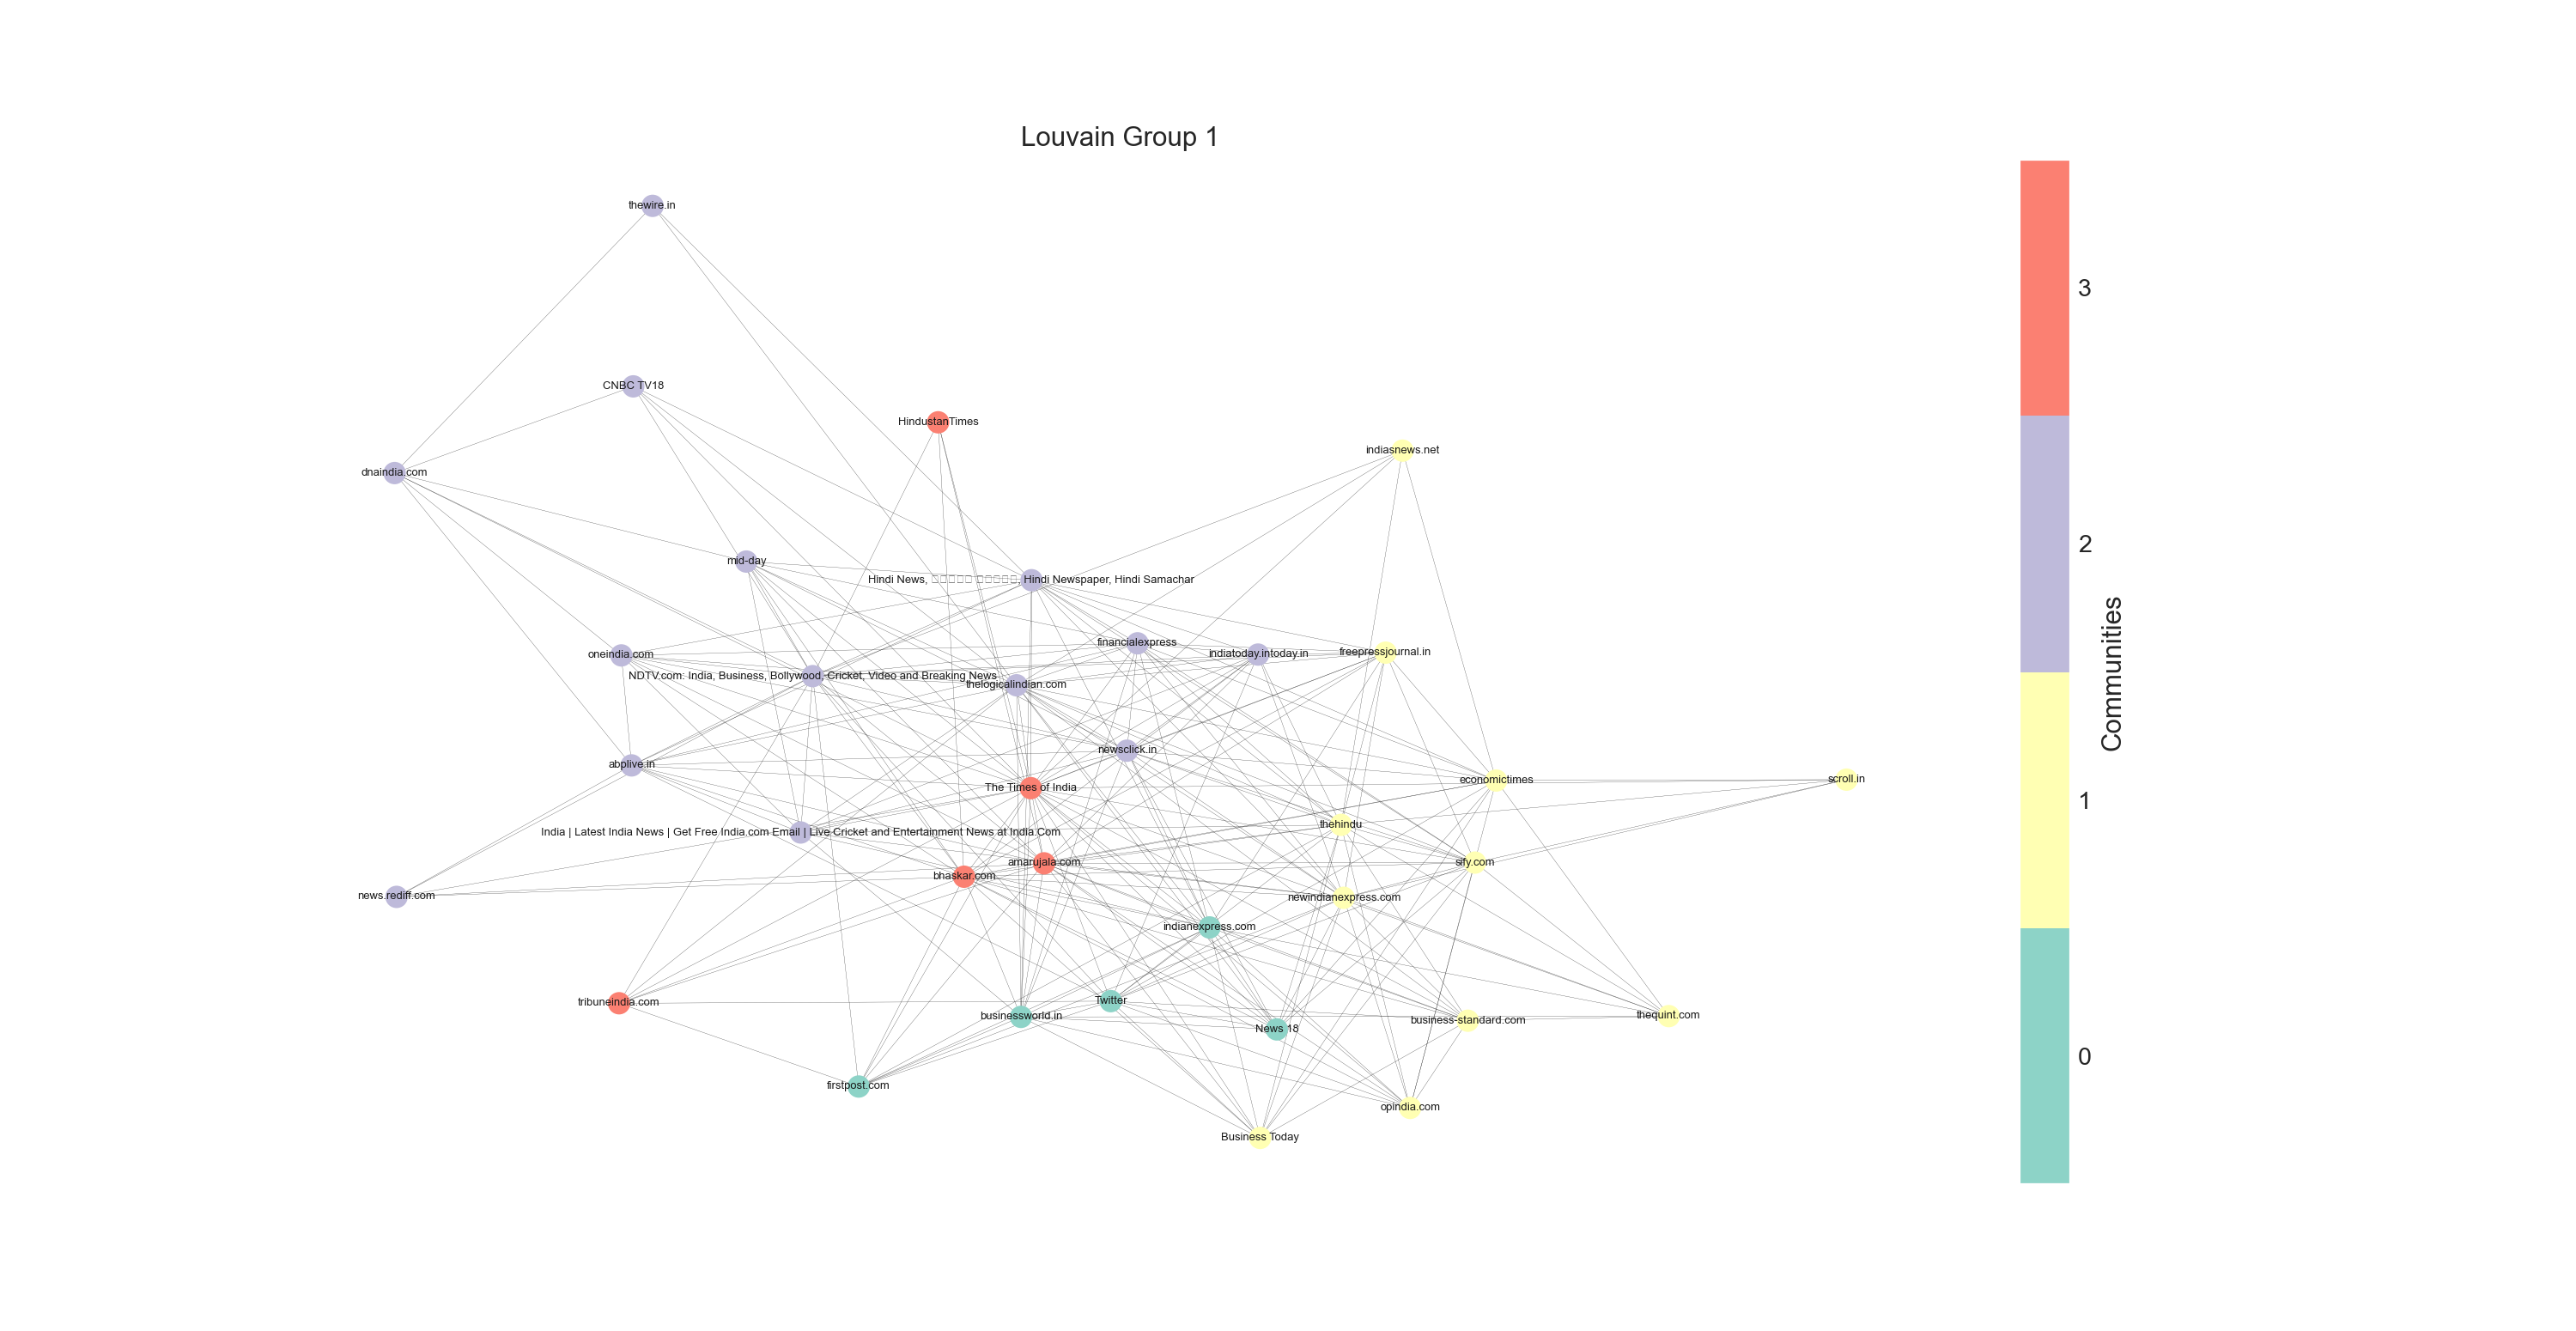

<IPython.core.display.Javascript object>


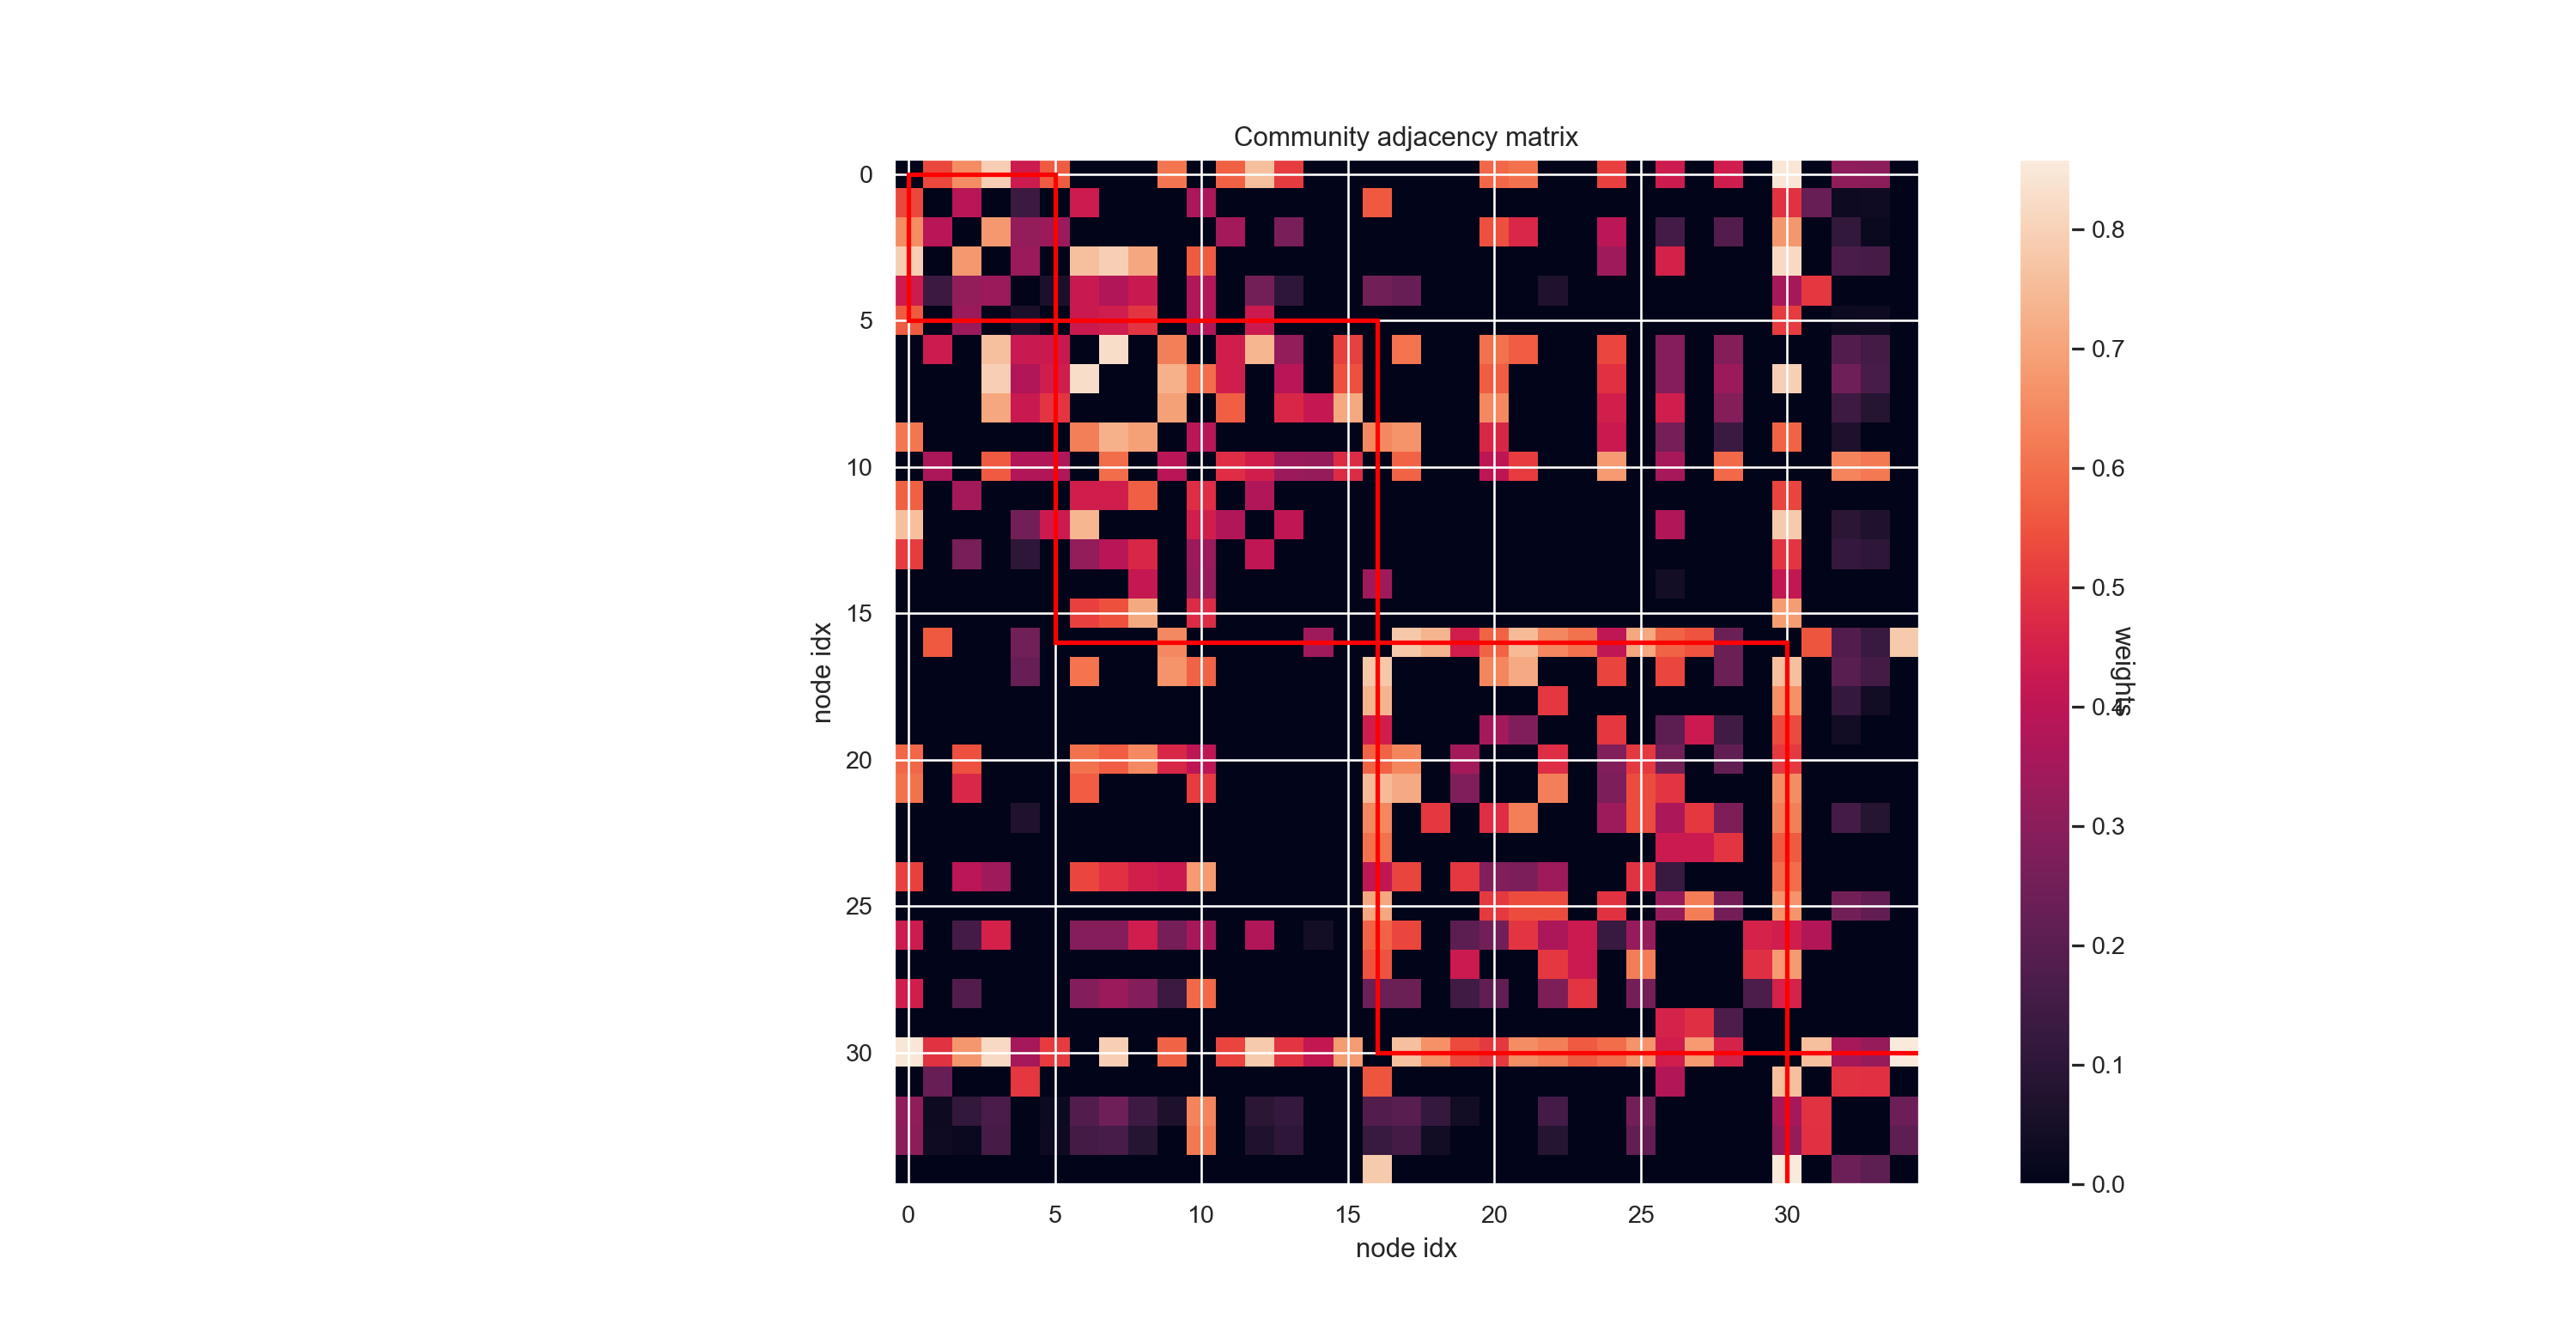

<IPython.core.display.Javascript object>


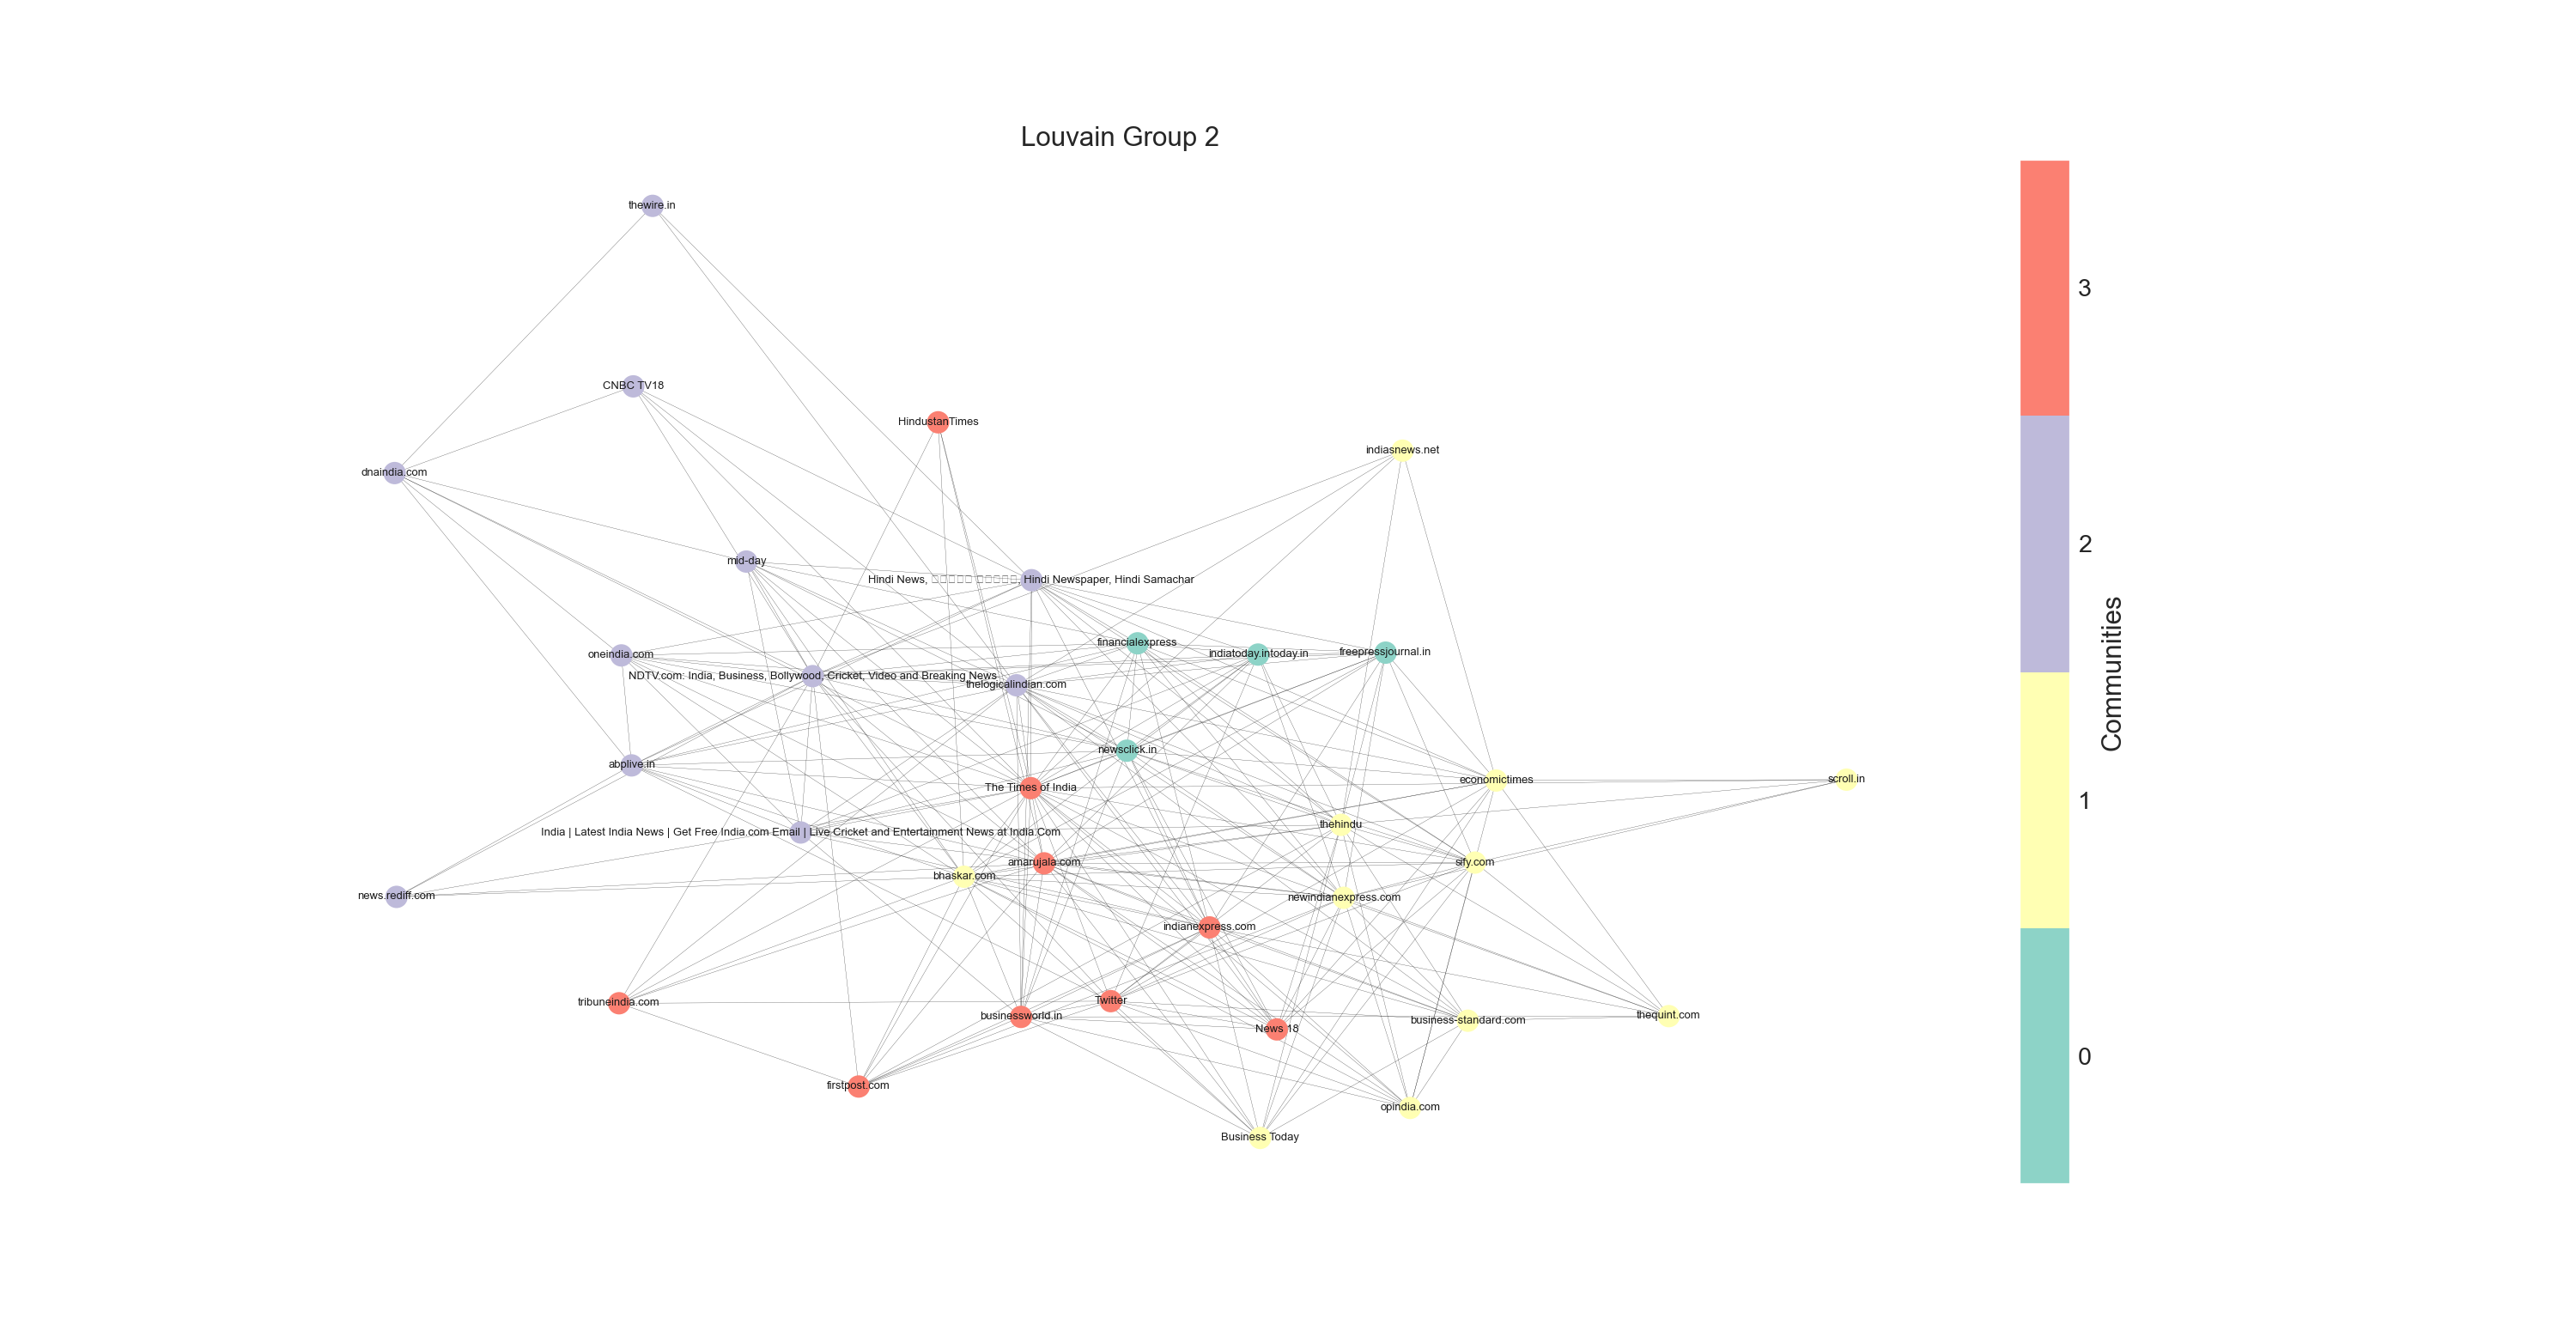

<IPython.core.display.Javascript object>


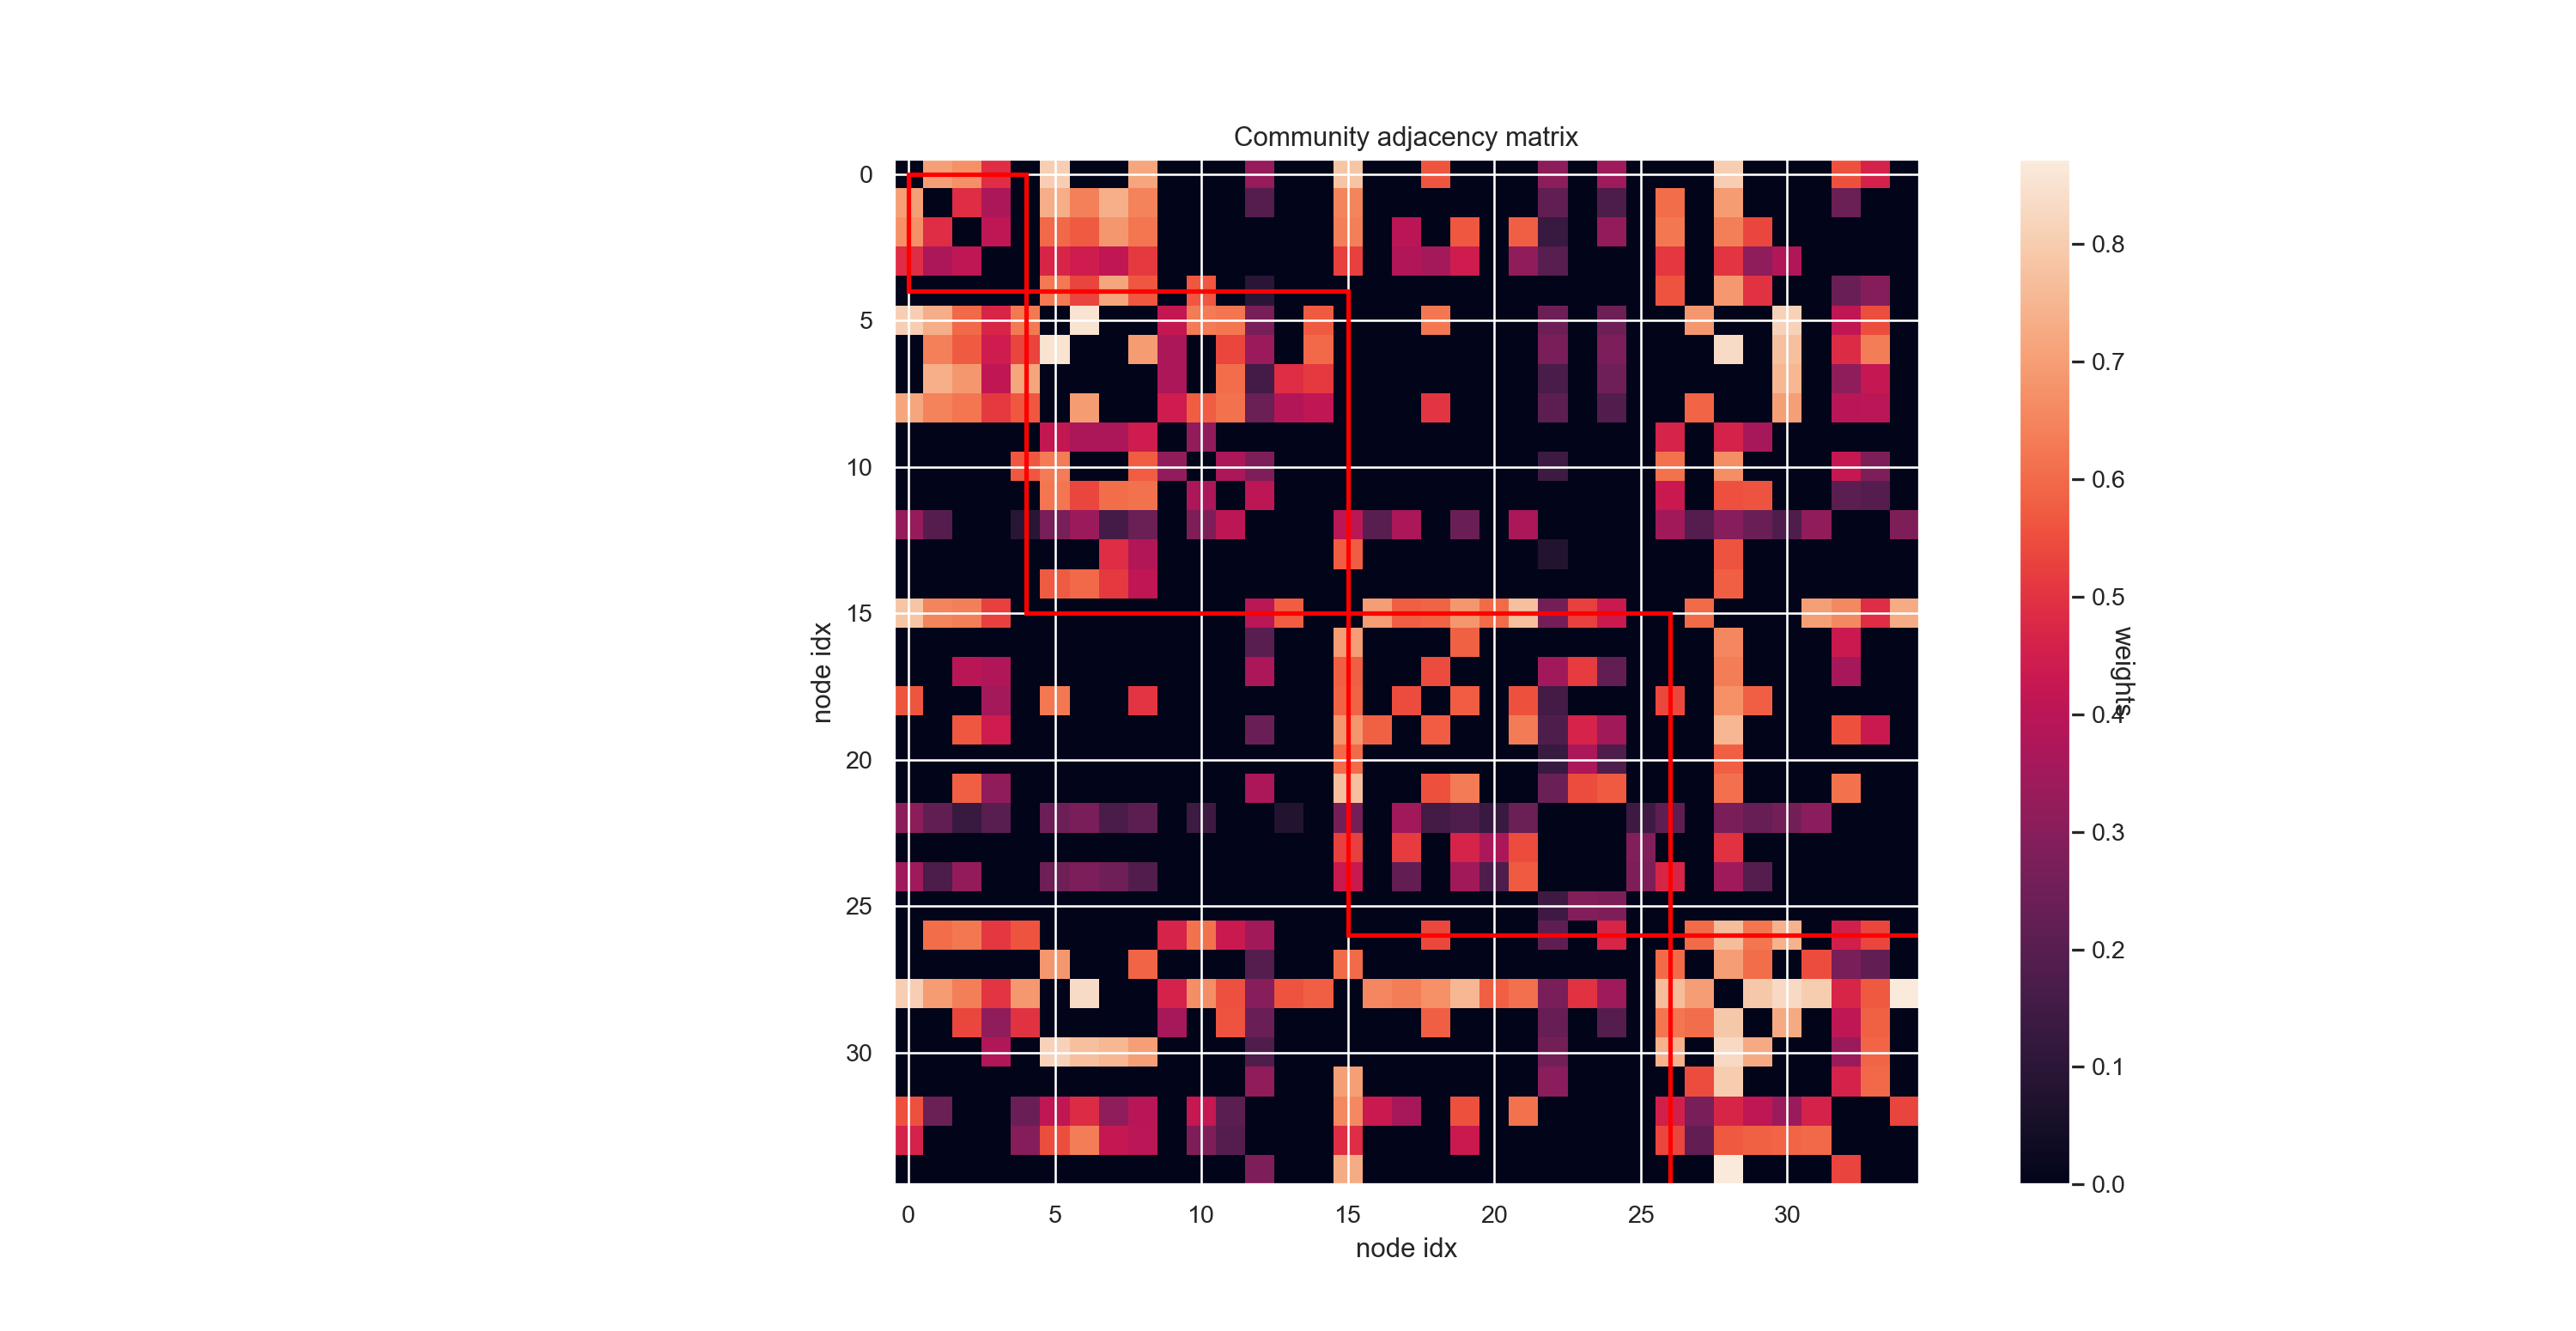

<IPython.core.display.Javascript object>


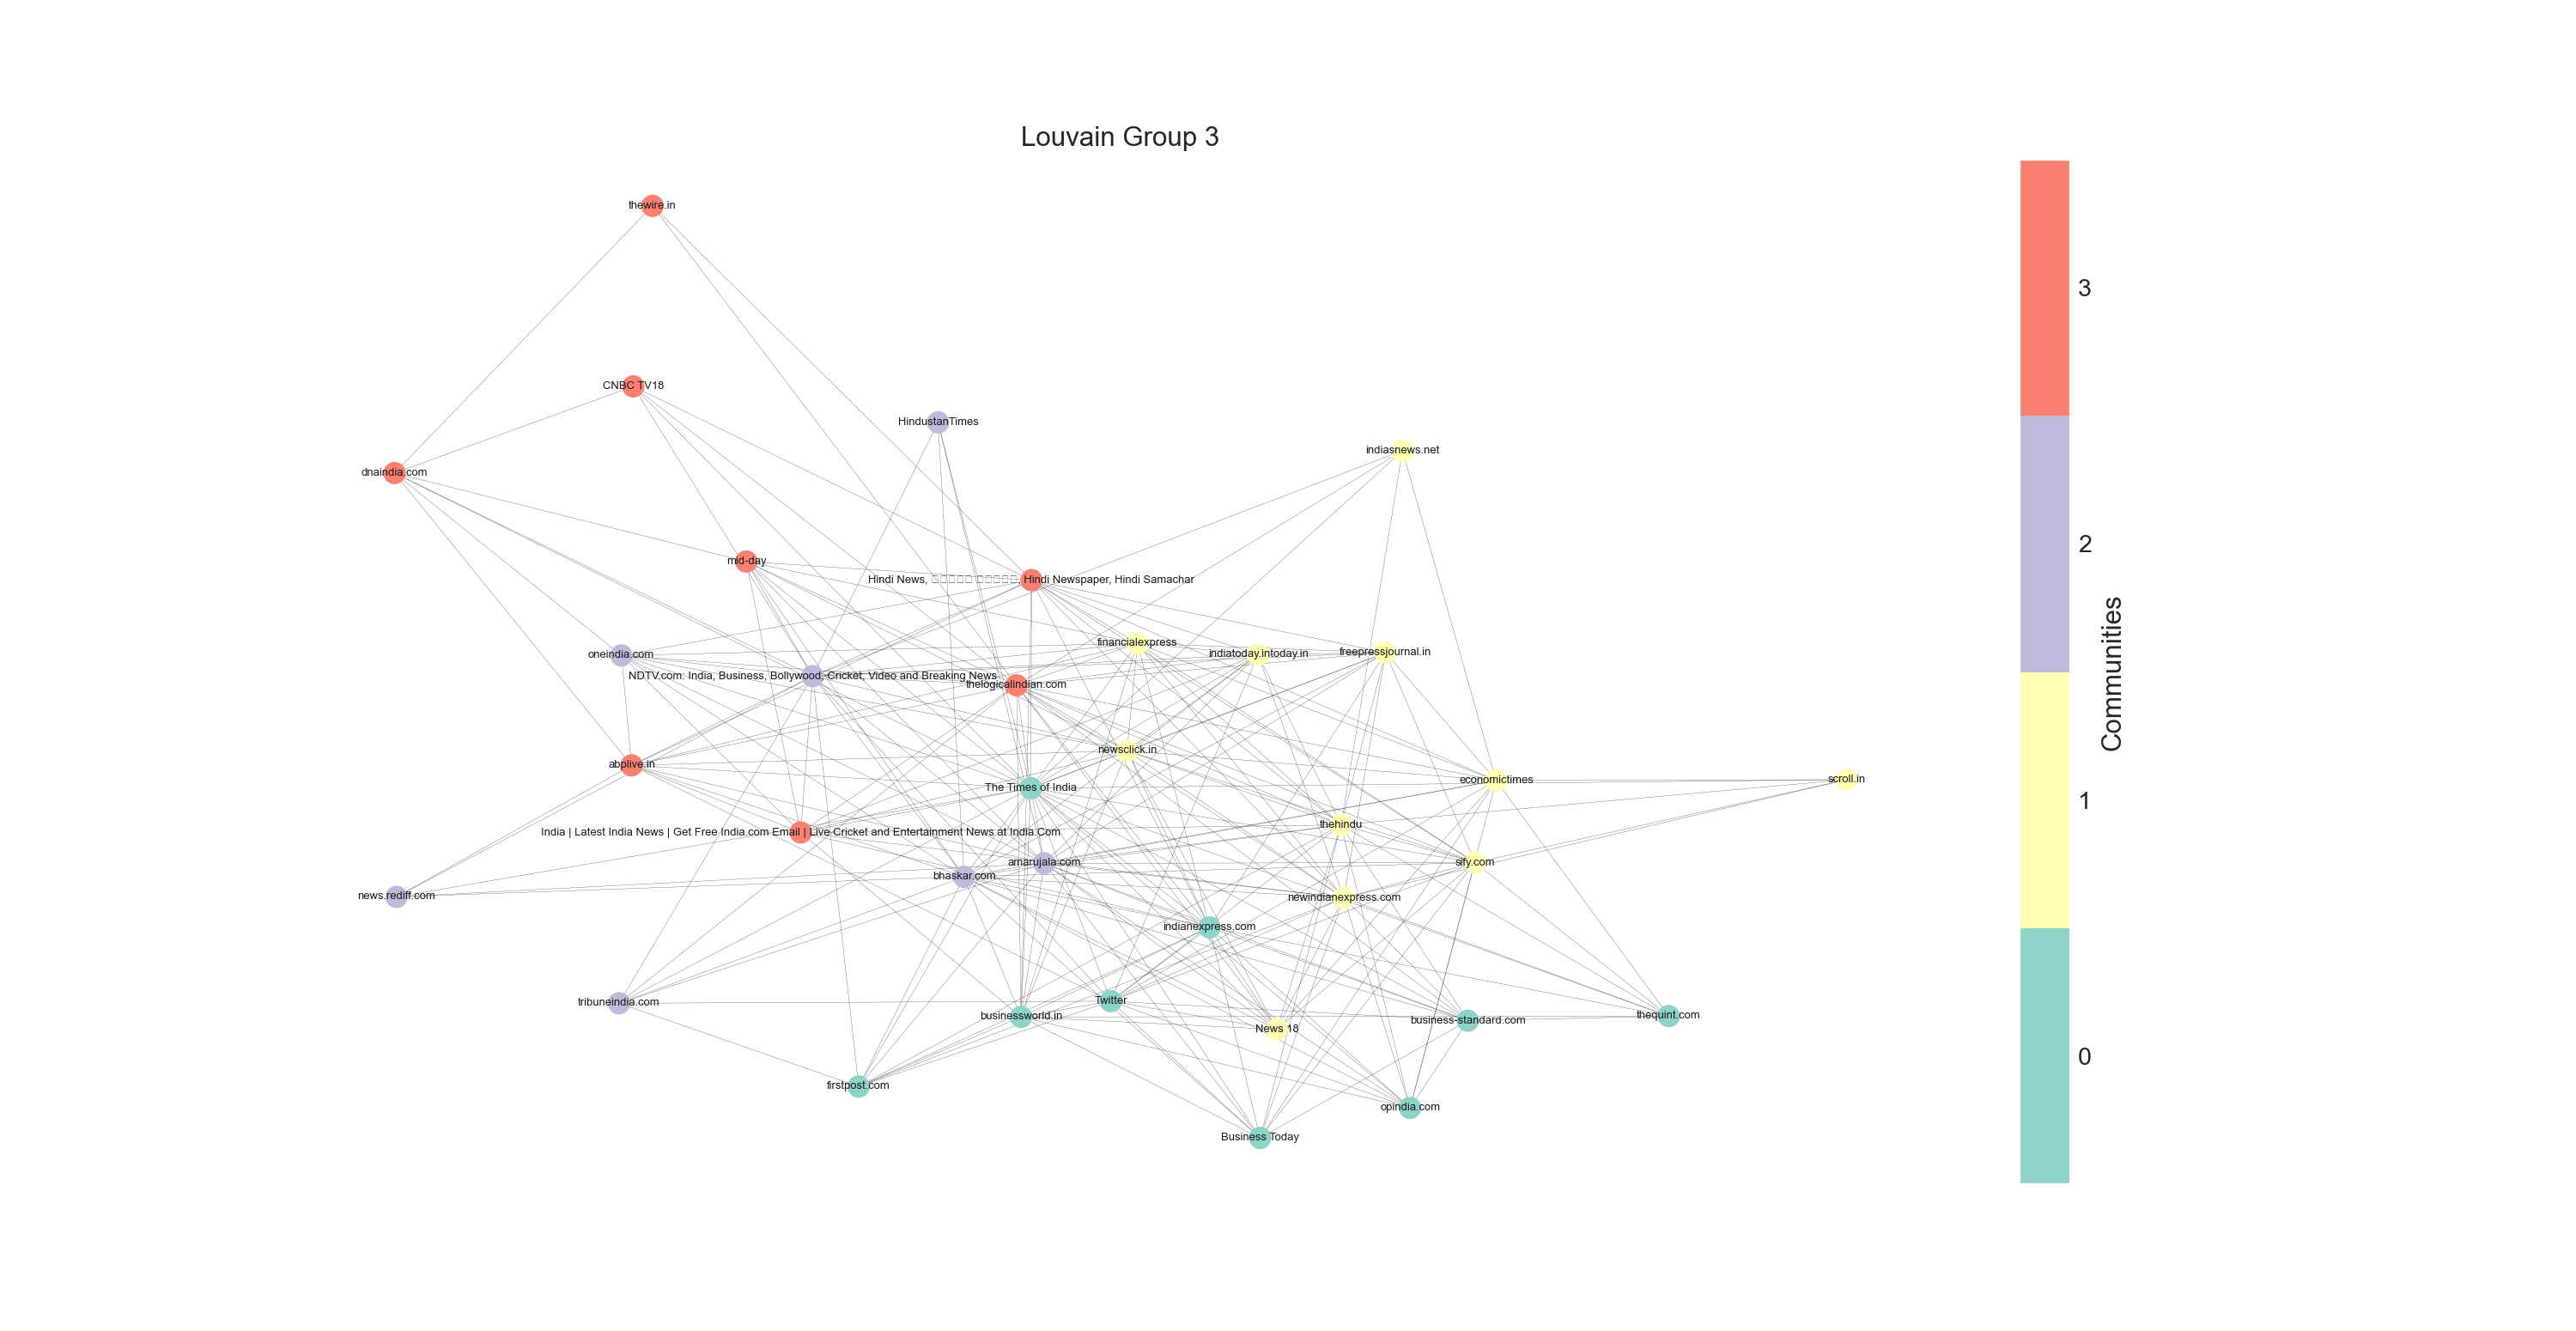

<IPython.core.display.Javascript object>


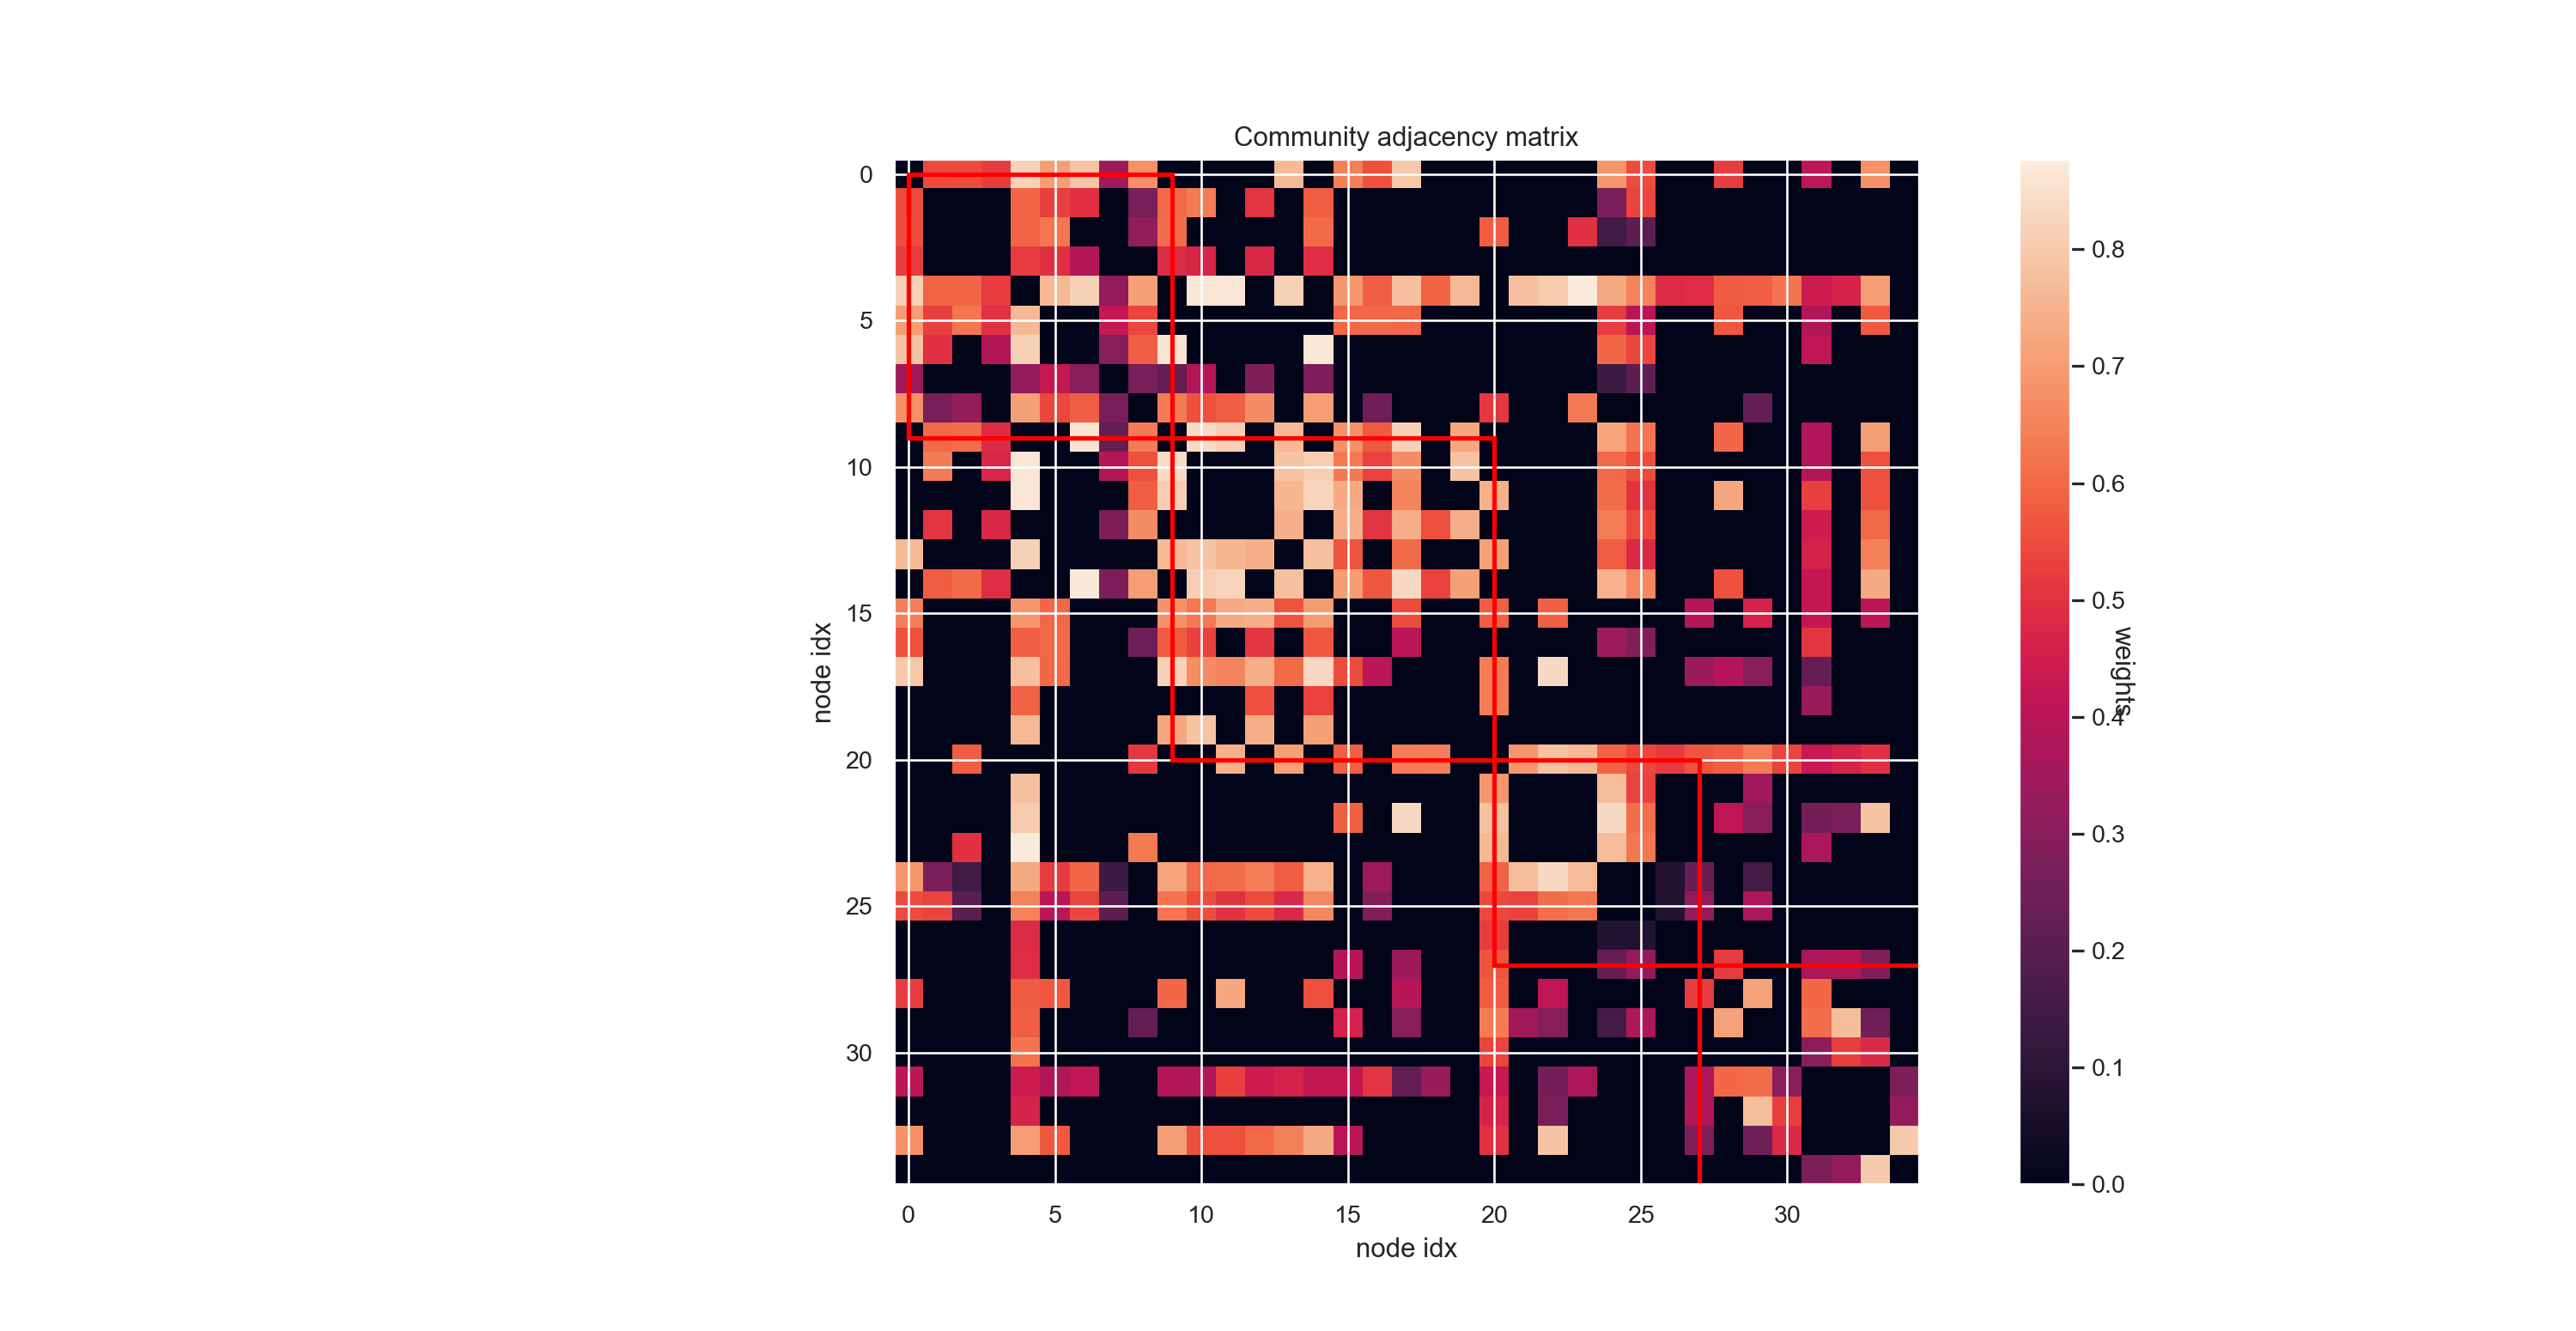

In [78]:
draw_clu(G1, pos1, louvain1 ,'Louvain Group 1' )
draw_grp_adj(G1, louvain1, weightAtrr = 'weight_G1' )

draw_clu(G2, pos2, louvain2 ,'Louvain Group 2' )
draw_grp_adj(G2, louvain2, weightAtrr = 'weight_G2')

draw_clu(G1, pos3, louvain3 ,'Louvain Group 3' )
draw_grp_adj(G3, louvain3, weightAtrr = 'weight_G3')

In [188]:
nx.write_gexf(G1, 'graph_G1.gexf')
nx.write_gexf(G2, 'graph_G2.gexf')
nx.write_gexf(G3, 'graph_G3.gexf')

In [137]:
#Collect intersecting couples

def getLouvainList(louvain):
    sourceList = []
    uniqueClasses = list(set(louvain1.values()))
    for i in range(len(uniqueClasses)):
        sourceList.append([k for k,v in louvain1.items() if v == i])
    return sourceList

def mostRepeated(louvain1, louvain2, louvain3):
    LL1 = getLouvainList(louvain1)
    LL2 = getLouvainList(louvain2)
    LL3 = getLouvainList(louvain3)
    repeatList = []
    for i in range(len(LL1)):
        for j in range(len(LL2)):
            for k in range(len(LL3)):
                s = set(LL1[i]) & set(LL2[j]) & set(LL3[k])
                if bool(s) == True:
                    repeatList.append(list(s))
    return repeatList

repeatList = mostRepeated(louvain1, louvain2, louvain3)

In [189]:
repeatList

[['businessworld.in',
  'News 18',
  'indianexpress.com',
  'Twitter',
  'firstpost.com'],
 ['thehindu',
  'sify.com',
  'indiasnews.net',
  'newindianexpress.com',
  'Business Today',
  'thequint.com',
  'freepressjournal.in',
  'opindia.com',
  'scroll.in',
  'economictimes',
  'business-standard.com'],
 ['NDTV.com: India, Business, Bollywood, Cricket, Video and Breaking News',
  'abplive.in',
  'thewire.in',
  'oneindia.com',
  'India | Latest India News | Get Free India.com Email | Live Cricket and Entertainment News at India.Com',
  'indiatoday.intoday.in',
  'CNBC TV18',
  'thelogicalindian.com',
  'dnaindia.com',
  'news.rediff.com',
  'financialexpress',
  'newsclick.in',
  'Hindi News, हिंदी न्यूज़, Hindi Newspaper, Hindi Samachar',
  'mid-day'],
 ['amarujala.com',
  'The Times of India',
  'HindustanTimes',
  'bhaskar.com',
  'tribuneindia.com']]

# Result: Analysis of the network Clusters

In [140]:
#Let's take a smaller cluter
repeatList[3]

['amarujala.com',
 'The Times of India',
 'HindustanTimes',
 'bhaskar.com',
 'tribuneindia.com']

In [207]:
#Trying to find the cluster where the contributio of all the newspapers is more
compG1 = NormComparisionDf(result_G1)
compG1.loc[:,repeatList[3]].sort_values(by = repeatList[3], ascending = False).head(10)

amarujala.com  The Times of India  HindustanTimes  bhaskar.com  \
48       0.500000            0.035714        0.005587        0.500   
44       0.222222            0.056122        0.072626        0.250   
19       0.055556            0.035714        0.044693        0.000   
4        0.055556            0.010204        0.016760        0.000   
10       0.055556            0.005102        0.027933        0.000   
40       0.055556            0.005102        0.000000        0.000   
46       0.055556            0.000000        0.005587        0.125   
59       0.000000            0.056122        0.083799        0.000   
57       0.000000            0.051020        0.027933        0.000   
38       0.000000            0.045918        0.027933        0.000   

    tribuneindia.com  
48          0.048193  
44          0.138554  
19          0.018072  
4           0.006024  
10          0.006024  
40          0.018072  
46          0.006024  
59          0.012048  
57          0.036145  
38          0.042169

In [210]:
#Group 44 seems to be the most susbtantial group
comp11 = result_G1[result_G1.newspaper.isin(repeatList[3]) & (result_G1.labels == 44)].title.to_list()
comp12 = result_G1[result_G1.newspaper.isin(repeatList[3]) & (result_G1.labels == 48)].title.to_list()
comp1 = comp11 + comp12
comp1

['अमृतसर में किसानों का रेल रोको आंदोलन छठे दिन भी जारी',
 'Haryana farmers protest delay in procurement of paddy, block highway',
 'Farmers continue rail blockade in Amritsar',
 'टांडा-दारापुर रेलवे ट्रैक पर किसानों का धरना, केंद्र सरकार के खिलाफ नारेबाजी, कहा, विधेयक रद्द होने तक जारी रहेगा संघर्ष',
 'Farm bills protests: Farmers continue to block rail tracks in Punjab',
 'Farmers across country hit the streets; rail, road traffic disrupted in many states',
 'Farmers block Bengaluru highway in Mandya, traffic thrown out of gear',
 '‘Withdraw farm Bills’: Protesting farmers block roads across dist',
 'Young farmers hit roads in Mohali as stir enters Day 3',
 'कहीं हाईवे किया जाम कहीं थाना गेट पर दिया धरना',
 'Farmers block roads, railway tracks as protests mount over farm bills',
 'Farmers continue rail blockade in Amritsar',
 'Farm bills: Farmers protest, block Delhi-Noida traffic at Sector 14-A',
 "Farmers' protest live: Rail, traffic movement hit",
 'Bhartiya Kisan Union members bl

**Comment: Group talks about farmers blocking road and solidarity between farmers and other groups**

In [176]:
#Same process for Group 2
compG2 = NormComparisionDf(result_G2)

compG2.loc[:,repeatList[3]].sort_values(by = repeatList[3], ascending = False).head(10)

amarujala.com  The Times of India  HindustanTimes  bhaskar.com  \
66       0.158730            0.025641        0.040541     0.043478   
94       0.095238            0.014245        0.010135     0.086957   
84       0.079365            0.045584        0.023649     0.086957   
77       0.079365            0.014245        0.013514     0.000000   
22       0.079365            0.000000        0.016892     0.000000   
55       0.063492            0.045584        0.037162     0.043478   
10       0.047619            0.022792        0.023649     0.173913   
81       0.047619            0.008547        0.013514     0.043478   
68       0.031746            0.025641        0.030405     0.043478   
83       0.031746            0.017094        0.010135     0.000000   

    tribuneindia.com  
66          0.019763  
94          0.027668  
84          0.019763  
77          0.019763  
22          0.000000  
55          0.098814  
10          0.023715  
81          0.007905  
68          0.011858  
83          0.007905

In [200]:
comp21 = result_G2[result_G2.newspaper.isin(repeatList[3]) & (result_G2.labels.isin([66]))].title.to_list()
comp21

['Tikri, Dhansa borders closed for traffic as farmers continue agitation against ...',
 'Stir sharpens on Delhi borders and in Punjab',
 'Police deploy cargo containers as barricades at Singhu border',
 'Farmers Protest: फिरोजाबाद में पुलिस की सपा कार्यकर्ताओं से झड़प, हिरासत में लिए कई नेता',
 "Farmers' protest: Security up in Gurugram",
 'विरोध प्रदर्शन के अंदेशे में किसानों व राजनीतिक दलों के 11 नेता घरों में रहे नजरबंद',
 'Farmers Protest: यमुना एक्सप्रेसवे पर शांति मार्च निकालने के एलान के बाद किसान नेता गिरफ्तार',
 'Farmers Protest: एक्सप्रेसवे और हाईवे पर पुलिस का सख्त पहरा, मथुरा में कई किसान गिरफ्तार',
 'सिंघु बॉर्डर पर डीसीपी व एडीसीपी कोरोना पॉजीटिव मिलने के बाद खतरा बढ़ा',
 "Delhi: Security up as farmers' stir likely to intensify",
 'Security up in Gurugram',
 'When a 2,000-vehicle convoy headed to Singhu border',
 'Security up in Gurugram as farmers stopped on Haryana-Rajasthan border',
 'Protests peaceful, cops seal Bhopal borders',
 'Bharat Bandh: Delhi Police beef up se

**Comments: Talks about police reaction to the reaction to the protesting farmers**

In [201]:
comp22 = result_G2[result_G2.newspaper.isin(repeatList[3]) & (result_G2.labels.isin([55]))].title.to_list()
comp22

['This salon is grooming farmers for protest',
 "Farmers' protest: Physiotherapists provide free therapy to elder people",
 'Medical staff takes shelter at Singhu Border to serve protesting farmers',
 'Tent city: The new go-to lodging spot for protesters at Singhu border',
 "Farmers uproot BJP workers' tent in Fatehabad for fast backing farm laws",
 'Mission Cleanliness at border',
 'Farmers at Ghazipur border set up ‘Neki ki divar’ for protesters',
 'Doctors from Punjab set up two-day eye-examination camp for protesting farmers at Singhu border',
 'Cow dung cakes sent to Singhu, Tikri for bonfire',
 'Water heaters, firewood for Tikri protesters to fight chill',
 "Indian doctors' group from USA delays return to help protesting farmers",
 "Medics in Ludhiana worried about public health as farmers' protest enters Day 21",
 'Insulated, waterproof tents installed at Singhu border for protesting farmers',
 'किसानों को शीतलहर से बचाने के लिए पंजाब से पहुंची वाटरप्रूफ झोपड़ी',
 'Tikri protest

**Comments: Talks about the aids provided to protesting farmers by various communities**

In [203]:
comp2 = comp21 + comp22

In [206]:
#Same process for Group 3
compG3 = NormComparisionDf(result_G3)
compG3.loc[:,repeatList[3]].sort_values(by = repeatList[3], ascending = False).head(10)

amarujala.com  The Times of India  HindustanTimes  bhaskar.com  \
54       0.403846            0.116822        0.000000     0.222222   
44       0.134615            0.018692        0.000000     0.000000   
45       0.115385            0.032710        0.000000     0.111111   
18       0.076923            0.070093        0.000000     0.333333   
10       0.038462            0.014019        0.043478     0.000000   
20       0.038462            0.009346        0.000000     0.000000   
32       0.038462            0.004673        0.000000     0.000000   
24       0.019231            0.046729        0.086957     0.000000   
43       0.019231            0.032710        0.130435     0.000000   
49       0.019231            0.032710        0.086957     0.000000   

    tribuneindia.com  
54          0.125984  
44          0.023622  
45          0.055118  
18          0.047244  
10          0.031496  
20          0.023622  
32          0.015748  
24          0.023622  
43          0.015748  
49          0.031496

In [204]:
comp3 = result_G3[result_G3.newspaper.isin(repeatList[3]) & (result_G3.labels.isin([18]))].title.to_list()
comp3

['किसानों ने 14 स्थानों पर नेशनल और स्टेट हाईवे किए जाम',
 "Decision by Tikait to not have 'chakka jam' in UP, U'khand taken in 'hasty manner', says SKM leader",
 "Farmers' 'chakka' jam' protest draws response in Punjab, Haryana, Rajasthan; scattered demonstrations in other states",
 'Karnataka: Chakka jam partially succeeds',
 "TN farmers stage protests, support 'chakka jam'",
 "'Chakka jam': Farmers block roads in Punjab, Haryana",
 'Chakka jam: Farmers in Rajasthan block roads',
 "'Chakka jam' by protesting farmers: Top developments",
 "'Chakka jam': Farmers in Punjab, Haryana block roads",
 'Chakka Jam: Farmers, Congress workers block NH-12 on the outskirts of Bhopal',
 'छत्तीसगढ़ में नेशनल हाईवे और स्टेट हाईवे पर किसान संगठन रोकेंगे रास्ता; शहरों में असर नहीं, लेकिन दूसरे जिले गए तो फंसेंगे',
 'किसान आंदोलन के समर्थन में 3 घंटे इंदौर में जाम रहेगा हाईवे, राऊ पिगडंबर एबी रोड पर किसान करेंगे चक्का जाम',
 'देशभर में नेशनल और स्टेट हाईवे जाम करेंगे किसान; दिल्ली-NCR, यूपी, उत्तराखंड मे

**Comments: Talks about road blocks**

In [211]:
#Compiling the text from all the groups 
newDict = {'sources' : ['groupOne', 'groupTwo', 'groupThree'],
           'Text' : [comp1,
                     comp2,
                     comp3]}


newCorpus = pd.DataFrame(newDict)
newCorpus['allText'] = [' '.join(newCorpus.iloc[i][1]) for i in range(len(newCorpus.Text))]

In [ ]:
#removing stop words
stops = stop_words = set([i.lower() for i in stopwords.words('english')])

#TF_IDF vectorisation
vectorizer = TfidfVectorizer(stop_words= stops)

transformed_texts = vectorizer.fit_transform(newCorpus['allText'])
transformed_text_array = transformed_texts.toarray()

#########################################################################

#Ranking the high scored TF-IDF words
tf_idf_dataframes = []

#processing each of the group
for counter, txt in enumerate(transformed_text_array):
    
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), txt))
    #Sorting words by TF-IDF scores 
    tf_idf_dataframes.append(pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)['term'])

#Making a Data frame from rankings
tf_idf_doc_comparison = pd.DataFrame(tf_idf_dataframes).T
tf_idf_doc_comparison.columns = newCorpus.sources
tf_idf_doc_comparison.index.names = ['Tf-IDF Ranking']

In [213]:
#Top 15 wrods for each group
tf_idf_doc_comparison.iloc[:15,:36]

sources        groupOne    groupTwo  groupThree
Tf-IDF Ranking                                 
0               farmers     farmers      chakka
1                 bills      border         jam
2                  farm      singhu     farmers
3                 block       delhi          ईव
4               protest     protest       roads
5                  rail  protesting       block
6                 roads    security         शनल
7               traffic      police          पर
8                   hit          पर     haryana
9                    शन     doctors      punjab
10                  रदर       tikri          कर
11                noida        camp          और
12              haryana     medical  expressway
13                   यक          सप         top
14              highway        food    february

In [ ]:
result nnot a generic tool
Frames are just topics, not fine
Louvain differs.
UMAP + HDBSCAN optimisation, different results. 